## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result:

undistort image


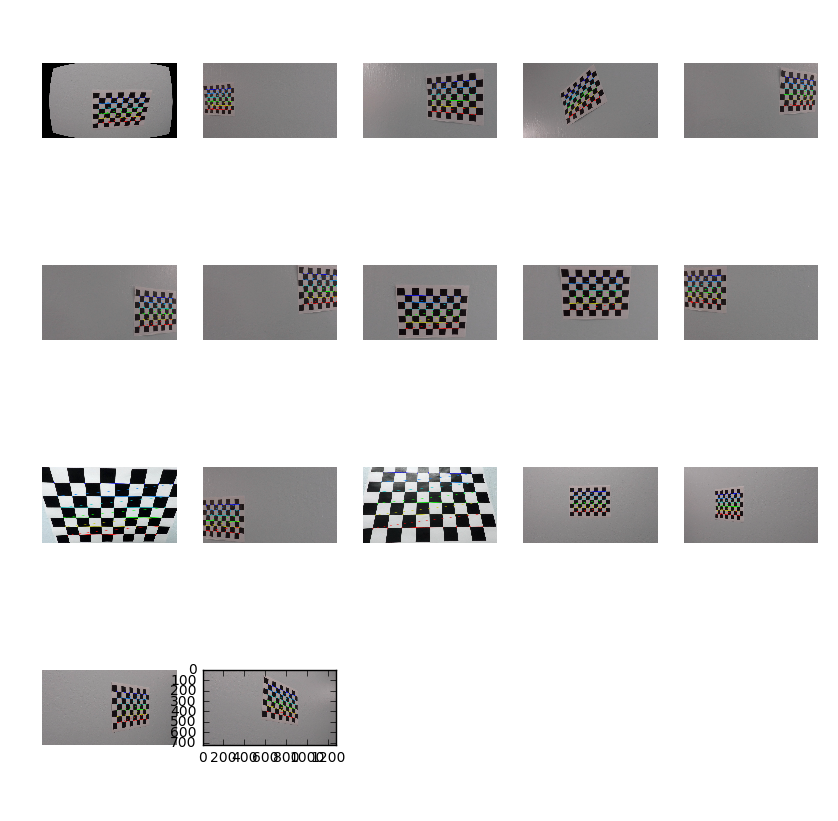

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

figure = plt.figure(figsize=(10,10))
factors = [4,5]
ind=0
mtx=None
dist=None

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)        
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        plt.axis("off")

        img = figure.add_subplot(factors[0],factors[1],ind + 1)
        plt.imshow(dst, cmap='gray')
        ind+=1

print('undistort image')


## gradient and thresholded
I used a combination of color and gradient thresholds to generate a binary image.  Here's an example of my output for this step.I combined Sobel operator and HLS color thresholds, which I use two thresholds, Sobel is (20,100), and HLS threshold is (170,250). I use Sobel x, and use plt.imshow to show the image

Then I use S channel threshold, I have tried H and L, but I found that S is better. Then I combined both together, you can see the picture below.

In [2]:
def gradient(img, s_thresh=(170, 250), sx_thresh=(20, 100),debug=False):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #s_channel = hls[:,:,0]
    #s_channel = hls[:,:,1]
    

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Plotting thresholded images
    if debug:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary, cmap='gray')

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
    
    return combined_binary

print('graint image')

graint image


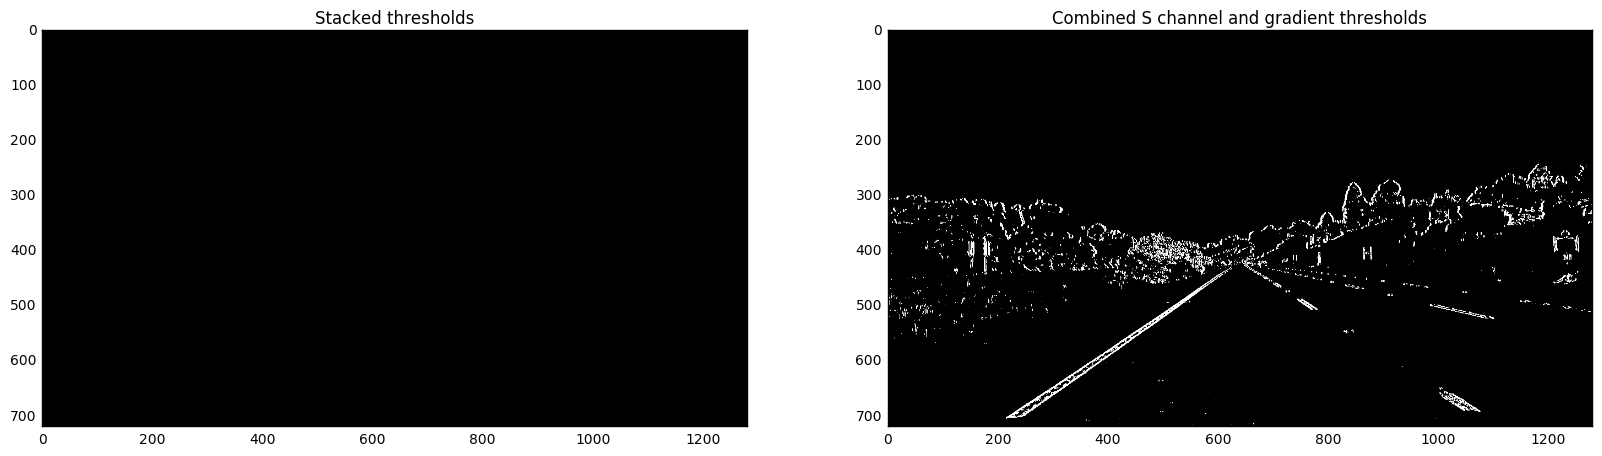

In [12]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
image = gradient(img,s_thresh=(175, 250), sx_thresh=(30, 150),debug=True)

## perspective transform

Then I use pers_tranform to transform the lane line.Then function is called pers_transform, which take 3 params inputs, image-the source image, src-the source base points, dst-the destination points, I also draw lines of source points and destionation points, you can also see them in the image below. 

Then I use getPerspectiveTransform and warpPerspective to take the transform.

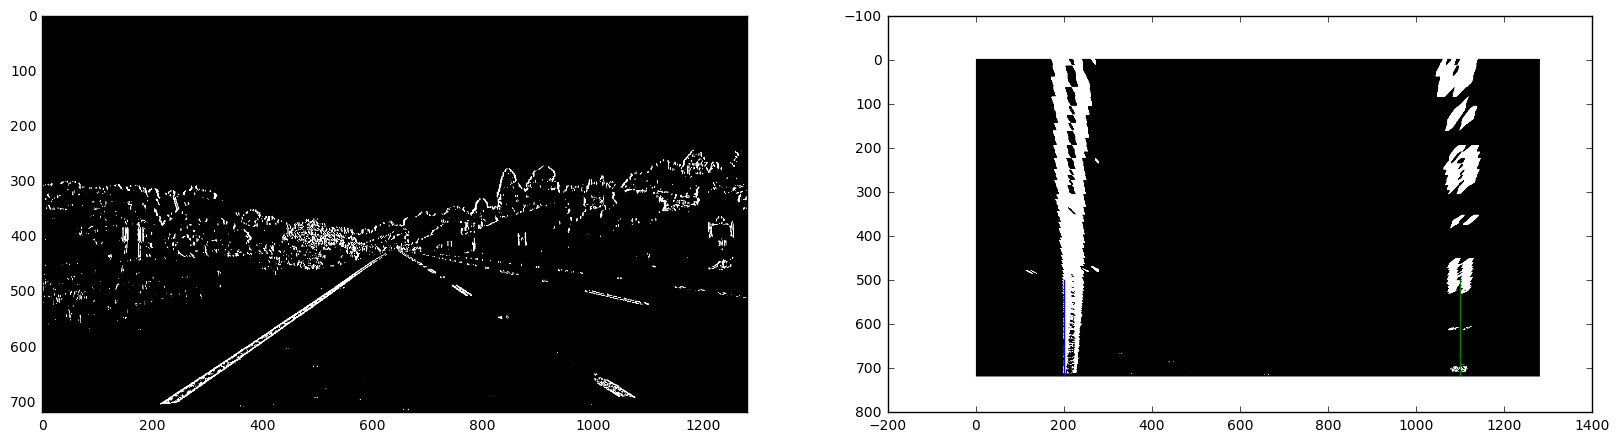

In [32]:
def pers_tranform(image,src,dst,debug=False):
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])       
    if debug:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
        ax1.imshow(image, cmap='gray')
        #ax1.plot((-150,420),(710,500))
        #ax1.plot((2000,1000),(710,500))
        
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size,flags=cv2.INTER_LINEAR)
    if debug:
        ax2.imshow(warped, cmap='gray')
        ax2.plot((200,200),(500,715))
        ax2.plot((1100,1100),(500,715)) 
    
    return warped

src = np.float32([[520,500],[763,500],[200,715],[1100,715]])
#src = np.float32([[420,500],[1000,500],[-150,710],[1950,710]])
dst = np.float32([[200,500],[1100,500],[200,715],[1100,715]])
#dst = np.float32([[0,0],[1000,0],[0,500],[1000,500]])





per_image= pers_tranform(image,src,dst,debug=True)


## Implement Sliding Windows and Fit a Polynomial
In order to get the polynomial of the lines, I implement a sliding windows search. First I take a histogram of the bottom half of the image. Then I find the peak of the left and right halves of the histogram to be the starting point for the left and right line. 

Then I use a sliding windows search, if the nonzero pixels in x and y within the window > minpix pixels, recenter next window on their mean position. And I also draw the line below.

## Draw back 
Then I draw back the curver to the road, first draw to the warped blank image, then I use warpPerspective to draw the image to the origan image, you can see the picture below

31925.364617 3896.26106235
10485.6285589 m 1261.88971148 m
lane_deviation 0.0583474075287


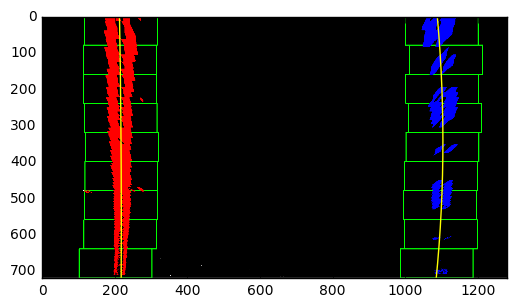

In [36]:
def window_search(img,warped,src,dst,debug=False):
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

    out_img = np.dstack((warped, warped, warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = warped.shape[0] * ym_per_pix
    scene_width = warped.shape[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    print('lane_deviation', lane_deviation)
    
    
    # draw the image back    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
     # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    M1 = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M1, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    #imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result,left_curverad,right_curverad,lane_deviation

result = window_search(img,per_image,src,dst,debug=True)

2451.43999453 1609.5214604
713.838168532 m 494.073560379 m
lane_deviation -0.185810755827


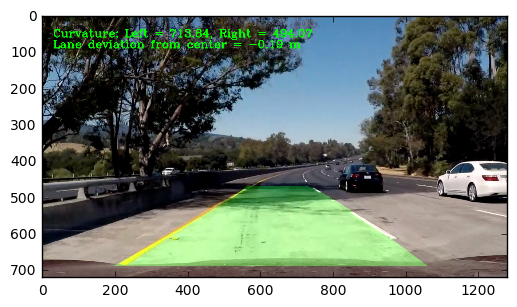

In [45]:

img = cv2.imread('test_images/test5.jpg')

def process_image(src_img):
    #src = np.float32([[520,500],[763,500],[200,715],[1100,715]])
    #dst = np.float32([[200,500],[1100,500],[200,715],[1100,715]])
    src = np.float32([[540, 470],[750, 470],
                      [1130, 690],[200, 690]])
    dst = np.float32([[200, 0], [1080, 0], 
                     [1080, 720],[200, 720]]) 

    image1 = gradient(src_img)
    per_image1= pers_tranform(image1,src,dst)

    out_image1,left_curverad,right_curverad,lane_deviation = window_search(src_img,per_image1,src,dst)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad, 2)) + ", Right = " + str(np.round(right_curverad, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(out_image1, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(out_image1, deviation_text, (30, 90), font, 1, (0,255,0), 2)
   
    return out_image1 

out_image = process_image(img)
out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

plt.imshow(out_image)


## the video pipline
Then I run the video pipline to output video

In [46]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'out_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

3435.18101125 7525.84947462
1109.91109309 m 2365.7091818 m
lane_deviation 0.337459067243
[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


  0%|          | 1/1261 [00:00<03:04,  6.84it/s]

3435.18101125 7525.84947462
1109.91109309 m 2365.7091818 m
lane_deviation 0.337459067243


  0%|          | 2/1261 [00:00<02:56,  7.12it/s]

3258.45708386 37728.9735804
1050.90647086 m 11572.8612082 m
lane_deviation 0.349389364735


  0%|          | 3/1261 [00:00<02:57,  7.08it/s]

3867.04760293 33103.2188275
1257.21911916 m 10147.7127141 m
lane_deviation 0.364587836079


  0%|          | 4/1261 [00:00<02:57,  7.06it/s]

3626.55781685 34447.316407
1177.88379163 m 10423.2218192 m
lane_deviation 0.36684420427


  0%|          | 5/1261 [00:00<03:05,  6.77it/s]

3416.07807084 3650.84601341
1107.52994419 m 1165.86269292 m
lane_deviation 0.340829737384


  1%|          | 7/1261 [00:01<03:29,  6.00it/s]

3747.31922384 5632.81092449
1218.82384748 m 1768.05736555 m
lane_deviation 0.355380694712
4036.04028946 4978.91673796
1316.35245033 m 1571.30916395 m
lane_deviation 0.359043761891


  1%|          | 9/1261 [00:01<03:05,  6.74it/s]

4118.65500541 4981.69160907
1344.3683303 m 1570.35131055 m
lane_deviation 0.357580405354
4132.11740399 2446.3733239
1349.66965167 m 795.934627144 m
lane_deviation 0.311742203832


  1%|          | 11/1261 [00:01<02:53,  7.22it/s]

4051.95114585 2184.9921271
1323.90499064 m 711.926835696 m
lane_deviation 0.315043996581
3700.01541797 3654.72688447
1207.73802091 m 1158.06152517 m
lane_deviation 0.349673474494


  1%|          | 13/1261 [00:01<02:59,  6.94it/s]

3559.69266728 3290.24362017
1163.41295337 m 1056.52702779 m
lane_deviation 0.337883148798
3611.35752808 4946.13223794
1180.26046433 m 1555.54102732 m
lane_deviation 0.352670438149


  1%|          | 15/1261 [00:02<03:06,  6.68it/s]

3211.3677127 16939.5829089
1047.76905634 m 4936.05470162 m
lane_deviation 0.395384527401
3391.18708148 28798.8118905
1107.209787 m 8446.98677785 m
lane_deviation 0.377071216624


  1%|▏         | 17/1261 [00:02<03:04,  6.73it/s]

5352.11701225 18094.2682464
1757.33556274 m 5284.70240552 m
lane_deviation 0.384263971472
4819.09114852 9184.96367906
1580.93691259 m 2796.9702039 m
lane_deviation 0.351190140385


  2%|▏         | 19/1261 [00:02<02:49,  7.33it/s]

6873.0282 16092.7725248
2257.45648134 m 4845.8981906 m
lane_deviation 0.360338756546
6946.9791677 86314.1639326
2281.74989031 m 25880.3683714 m
lane_deviation 0.355413763047


  2%|▏         | 21/1261 [00:03<02:48,  7.34it/s]

6667.37767653 22757.4230505
2189.91811531 m 6931.99030853 m
lane_deviation 0.341666220843
12133.4428998 4429.10693831
3981.75262313 m 1416.34539499 m
lane_deviation 0.298236579742


  2%|▏         | 23/1261 [00:03<02:41,  7.68it/s]

11776.5344725 4675.79751833
3865.37636091 m 1493.75541854 m
lane_deviation 0.30235794369
85988.5219837 2566.14437049
28167.2989665 m 835.754912821 m
lane_deviation 0.278738500673


  2%|▏         | 25/1261 [00:03<02:38,  7.82it/s]

13766.7534886 3474.49128616
4520.68815409 m 1116.09726529 m
lane_deviation 0.283010673126
8411.9339734 3849.07129192
2762.53727751 m 1228.98467822 m
lane_deviation 0.280075319572


  2%|▏         | 27/1261 [00:03<02:32,  8.08it/s]

6429.03805655 4142.55241196
2110.19699757 m 1323.7846277 m
lane_deviation 0.275284184321
5392.62076531 8772.68347237
1767.49176236 m 2739.45723089 m
lane_deviation 0.28996694118


  2%|▏         | 29/1261 [00:04<02:29,  8.24it/s]

5199.74172542 17059.1880127
1703.79564042 m 5303.82743063 m
lane_deviation 0.294900813123
5467.61164179 25608.2236768
1791.64008424 m 7921.12520318 m
lane_deviation 0.294286035745


  2%|▏         | 31/1261 [00:04<02:19,  8.79it/s]

5910.25850221 16047.7226516
1937.00538625 m 4976.53620963 m
lane_deviation 0.291495545903
5819.0027849 5653.85318085
1906.03402248 m 1778.2091707 m
lane_deviation 0.289942392486


  3%|▎         | 33/1261 [00:04<02:20,  8.73it/s]

4900.6956697 6684.75403375
1600.52267417 m 2086.61120529 m
lane_deviation 0.279612496525
5449.72677074 5527.91826215
1781.87867851 m 1744.63424365 m
lane_deviation 0.27500117106


  3%|▎         | 35/1261 [00:04<02:25,  8.44it/s]

4105.10530753 2595.38414987
1336.42106421 m 844.335299421 m
lane_deviation 0.224661680661
5737.51598872 2025.77744799
1876.03872637 m 661.623768315 m
lane_deviation 0.236521050275


  3%|▎         | 37/1261 [00:04<02:19,  8.76it/s]

4705.60415593 2629.73731875
1534.42382036 m 848.594570019 m
lane_deviation 0.255829789157
3743.1958489 3150.10056646
1214.5943887 m 1006.25688754 m
lane_deviation 0.258811889475


  3%|▎         | 39/1261 [00:05<02:15,  9.01it/s]

3398.53918079 5264.17485744
1099.11957186 m 1636.6673306 m
lane_deviation 0.282545232032
2864.40023612 12753.217355
920.882246784 m 3834.3904773 m
lane_deviation 0.294743388187


  3%|▎         | 41/1261 [00:05<02:13,  9.11it/s]

2765.23833845 9540.3318781
888.666850082 m 2903.23545391 m
lane_deviation 0.287431272508
2685.26659409 9943.13943967
862.670317921 m 3029.25125968 m
lane_deviation 0.285685193096


  3%|▎         | 43/1261 [00:05<02:17,  8.88it/s]

2696.34453591 7372.30319797
867.95331398 m 2268.38057575 m
lane_deviation 0.287734658388
3124.69087272 4383.46689431
1014.75686891 m 1373.30262335 m
lane_deviation 0.302170961343


  4%|▎         | 45/1261 [00:05<02:18,  8.75it/s]

3089.39217425 7445.02770416
1003.75278253 m 2309.66931504 m
lane_deviation 0.304077315706
3278.28164327 6506.57783865
1068.02063077 m 2032.43438344 m
lane_deviation 0.306839456707


  4%|▎         | 47/1261 [00:06<02:16,  8.89it/s]

2892.70684591 4363.59690363
939.953233698 m 1388.6963111 m
lane_deviation 0.277909060916
3276.20700362 2444.71498546
1068.25110439 m 796.151091166 m
lane_deviation 0.250860842993


  4%|▍         | 49/1261 [00:06<02:20,  8.64it/s]

3569.36425066 1882.99272928
1166.05427946 m 616.330892134 m
lane_deviation 0.244388149165
3526.15811654 2533.11904351
1152.44730998 m 820.514010329 m
lane_deviation 0.271983148237


  4%|▍         | 51/1261 [00:06<02:26,  8.26it/s]

3066.2894322 3097.40235617
999.867043051 m 990.451241964 m
lane_deviation 0.286219563384
2956.18924373 3111.66428551
963.843975625 m 994.916038909 m
lane_deviation 0.286151150501


  4%|▍         | 53/1261 [00:06<02:24,  8.36it/s]

2958.35405502 7935.71859014
965.128753227 m 2431.8772743 m
lane_deviation 0.314576558316
3180.72865523 20054.5531899
1039.31014761 m 6030.25259434 m
lane_deviation 0.319653256604


  4%|▍         | 55/1261 [00:07<02:23,  8.39it/s]

3187.19754215 11814.1146719
1041.15369406 m 3586.88142449 m
lane_deviation 0.302160166189
4259.48155 5247.48382296
1397.91439886 m 1630.8316488 m
lane_deviation 0.308666103283


  5%|▍         | 57/1261 [00:07<02:23,  8.40it/s]

5836.48192601 4626.34288797
1917.01044598 m 1445.95850051 m
lane_deviation 0.314271702862
6557.33263149 6231.27441953
2153.68675415 m 1928.76383974 m
lane_deviation 0.315635065798


  5%|▍         | 59/1261 [00:07<02:21,  8.50it/s]

7492.95711843 5144.82034541
2460.79757158 m 1612.93733173 m
lane_deviation 0.294949687507
10855.0870864 1790.15559811
3564.31733986 m 586.444827072 m
lane_deviation 0.214694133467


  5%|▍         | 61/1261 [00:07<02:22,  8.44it/s]

12429.9628789 2296.7563414
4082.04848878 m 739.408574478 m
lane_deviation 0.246095407938
10362.9497024 2364.69478752
3403.74300425 m 759.680826133 m
lane_deviation 0.237881717882


  5%|▍         | 63/1261 [00:07<02:21,  8.47it/s]

9038.28307001 4056.55615975
2967.95435136 m 1254.45197013 m
lane_deviation 0.265210675367
7053.80884669 10167.2132386
2314.13954084 m 3033.38153882 m
lane_deviation 0.278293905454


  5%|▌         | 65/1261 [00:08<02:23,  8.33it/s]

5715.60762973 14007.4546566
1871.49393244 m 4155.10837348 m
lane_deviation 0.266728347467
4758.46590122 24004.6492929
1554.62761824 m 7121.67001296 m
lane_deviation 0.253448491458


  5%|▌         | 67/1261 [00:08<02:22,  8.40it/s]

3751.27573772 6097.85689843
1219.19019387 m 1864.99899741 m
lane_deviation 0.225799212107
3893.84516719 9954.33812314
1267.83449613 m 3014.34510129 m
lane_deviation 0.227780426817


  5%|▌         | 69/1261 [00:08<02:24,  8.26it/s]

4056.34228728 21575.7618431
1322.06510732 m 6497.62845979 m
lane_deviation 0.221893493942
3790.56324602 39441.2667917
1232.92549833 m 11807.6694671 m
lane_deviation 0.215065660678


  6%|▌         | 71/1261 [00:08<02:22,  8.37it/s]

3460.28390763 271629.620718
1123.26195262 m 81873.8201142 m
lane_deviation 0.203449172581
3613.75422567 4180.44650585
1175.14401763 m 1326.46163984 m
lane_deviation 0.162897352581


  6%|▌         | 73/1261 [00:09<02:26,  8.11it/s]

3929.30734533 2874.85978467
1280.55768858 m 928.490330106 m
lane_deviation 0.139862961431
4211.96712438 3258.19347538
1374.71935305 m 1046.78641897 m
lane_deviation 0.14982757917


  6%|▌         | 75/1261 [00:09<02:27,  8.05it/s]

4589.44204014 4091.82228745
1500.42382085 m 1300.44299856 m
lane_deviation 0.16431567184
4896.90915441 4643.9843583
1602.98153048 m 1472.3258129 m
lane_deviation 0.167340549207


  6%|▌         | 77/1261 [00:09<02:23,  8.24it/s]

5056.39673016 5196.14947103
1656.10152718 m 1641.85501079 m
lane_deviation 0.168304253657
5298.60279477 5436.64169495
1736.80225343 m 1725.31025559 m
lane_deviation 0.167416552105


  6%|▋         | 79/1261 [00:09<02:22,  8.29it/s]

6630.85192465 9336.22322439
2175.86073536 m 2926.76738258 m
lane_deviation 0.17722419624
6105.40750485 6581.43977839
2002.32000871 m 2086.50422666 m
lane_deviation 0.162390919872


  6%|▋         | 81/1261 [00:10<02:20,  8.38it/s]

6333.3735759 15059.2701824
2076.79769447 m 4713.68751122 m
lane_deviation 0.157814938338
22699.3665641 4641.72694246
7454.68731435 m 1480.85808608 m
lane_deviation 0.165364182656


  7%|▋         | 83/1261 [00:10<02:21,  8.34it/s]

107746.754784 7765.7646636
35371.2803698 m 2455.15932019 m
lane_deviation 0.164612974475
154325.38366 8277.61833509
50664.4417872 m 2619.31186005 m
lane_deviation 0.152685541155


  7%|▋         | 85/1261 [00:10<02:18,  8.47it/s]

40255.5113926 6276.79799056
13220.5071261 m 2010.31597058 m
lane_deviation 0.139242262168
175403.064331 5551.65275351
57605.6149434 m 1783.27356689 m
lane_deviation 0.132293330797


  7%|▋         | 87/1261 [00:10<02:18,  8.48it/s]

103965.843225 2193.2014664
34147.8024054 m 718.780207132 m
lane_deviation 0.098128947537
16848.0798415 2752.53557968
5525.07124293 m 893.073428129 m
lane_deviation 0.108262896888


  7%|▋         | 89/1261 [00:11<02:17,  8.54it/s]

7849.41975329 3898.24454655
2560.51349645 m 1244.48715563 m
lane_deviation 0.112535771379
5569.92461164 10488.2098505
1807.36782818 m 3228.29066162 m
lane_deviation 0.137398505766


  7%|▋         | 91/1261 [00:11<02:17,  8.49it/s]

4653.15296508 17284.6973492
1502.62552603 m 5248.02033845 m
lane_deviation 0.140684140614
3943.16803353 18212.7115587
1266.68957879 m 5415.03111937 m
lane_deviation 0.14211955693


  7%|▋         | 93/1261 [00:11<02:17,  8.50it/s]

3983.3156949 9346.81797276
1281.01662725 m 2900.16118219 m
lane_deviation 0.124010615402
4642.28557151 9900.01622424
1501.04427775 m 3066.68950259 m
lane_deviation 0.134550949881


  8%|▊         | 95/1261 [00:11<02:16,  8.56it/s]

4396.24511757 10820.7168198
1420.03041927 m 3350.25013105 m
lane_deviation 0.137118858092
4472.18314048 32724.5992625
1446.84285795 m 10084.9039402 m
lane_deviation 0.136042898342


  8%|▊         | 97/1261 [00:12<02:16,  8.54it/s]

4693.45767497 4699.28859784
1521.37194411 m 1506.48536625 m
lane_deviation 0.099116114935
4800.63201744 2541.4663474
1557.68667289 m 828.950710878 m
lane_deviation 0.0803140767104


  8%|▊         | 99/1261 [00:12<02:14,  8.61it/s]

4897.09901203 2717.54776232
1590.51369228 m 885.5584431 m
lane_deviation 0.0872341930955
4604.8081018 3102.62254444
1493.70499827 m 1004.11138083 m
lane_deviation 0.105749655382


  8%|▊         | 101/1261 [00:12<02:16,  8.51it/s]

4492.08274642 2992.18936108
1455.81140943 m 971.29184186 m
lane_deviation 0.0998872710336
3940.16571959 3761.29745202
1272.75575561 m 1210.55209973 m
lane_deviation 0.113144309977


  8%|▊         | 103/1261 [00:12<02:18,  8.36it/s]

3845.72915494 5073.24308239
1240.78119844 m 1614.46260839 m
lane_deviation 0.124973799084
3654.68714528 6356.07327388
1177.2378136 m 2010.88729694 m
lane_deviation 0.134461707597


  8%|▊         | 105/1261 [00:13<02:24,  8.00it/s]

3871.48977653 6088.68750208
1250.94094339 m 1930.88133446 m
lane_deviation 0.140823090034
6049.85042101 10038.6088592
1977.10037348 m 3166.83796165 m
lane_deviation 0.173007827171


  8%|▊         | 107/1261 [00:13<02:24,  8.01it/s]

5102.47167218 5342.20055464
1662.81440658 m 1708.24797098 m
lane_deviation 0.166223369809
5180.52070194 5288.50569217
1688.95410038 m 1694.99146965 m
lane_deviation 0.175647861156


  9%|▊         | 109/1261 [00:13<02:21,  8.15it/s]

5020.73429216 8505.68433786
1635.18305091 m 2692.96233512 m
lane_deviation 0.190491423593
5271.78171091 14846.5670535
1718.35063331 m 4645.12497898 m
lane_deviation 0.210399566428


  9%|▉         | 111/1261 [00:13<02:18,  8.33it/s]

5312.46953471 3436.74375116
1731.4653579 m 1113.68794461 m
lane_deviation 0.175844249084
5908.16678061 2951.23839122
1927.70343168 m 956.65281429 m
lane_deviation 0.18724287842


  9%|▉         | 113/1261 [00:13<02:17,  8.32it/s]

5247.82803213 3298.1198404
1710.18138107 m 1069.92911093 m
lane_deviation 0.186344934589
4202.26210598 3770.88461279
1362.09654787 m 1214.30626421 m
lane_deviation 0.190917478276


  9%|▉         | 115/1261 [00:14<02:14,  8.51it/s]

3706.964938 7917.75659807
1197.50416832 m 2487.6877146 m
lane_deviation 0.218615446137
3202.67025907 18277.674314
1027.95720759 m 5635.40819407 m
lane_deviation 0.225716229511


  9%|▉         | 117/1261 [00:14<02:14,  8.48it/s]

4010.89674302 9626.04435697
1301.18941275 m 3007.63313892 m
lane_deviation 0.232465547564
4398.95178613 12014.4948738
1430.75046807 m 3747.65284546 m
lane_deviation 0.237761527019


  9%|▉         | 119/1261 [00:14<02:13,  8.55it/s]

3883.79616818 3793.50868196
1259.27344022 m 1214.53568259 m
lane_deviation 0.221351551738
4003.68942079 5116.92509767
1299.30549393 m 1624.19567807 m
lane_deviation 0.230633219786


 10%|▉         | 121/1261 [00:14<02:13,  8.55it/s]

3743.37985743 4848.14017299
1212.63812054 m 1536.85600122 m
lane_deviation 0.234778325295
3823.11822224 4587.36330755
1240.01373378 m 1462.14231404 m
lane_deviation 0.235152428364


 10%|▉         | 123/1261 [00:15<02:14,  8.45it/s]

3847.98313186 1894.54168461
1248.28054801 m 620.81772034 m
lane_deviation 0.195197869705
3523.60727691 2362.82552797
1140.24492247 m 767.213093857 m
lane_deviation 0.217103020508


 10%|▉         | 125/1261 [00:15<02:13,  8.49it/s]

3428.17260803 2438.07998432
1107.93340475 m 788.743454084 m
lane_deviation 0.228255716217
3308.63248472 2677.16168984
1067.88566903 m 861.414688205 m
lane_deviation 0.235990286483


 10%|█         | 127/1261 [00:15<02:13,  8.48it/s]

3357.73789117 3614.01380697
1085.7790402 m 1149.19255487 m
lane_deviation 0.258945254681
3120.06888756 4767.97047325
1006.08499334 m 1492.97066724 m
lane_deviation 0.273117656101


 10%|█         | 129/1261 [00:15<02:13,  8.45it/s]

2968.87700055 6145.370876
956.580333064 m 1912.64858413 m
lane_deviation 0.279681346824
3623.93012415 4758.56285658
1179.63140673 m 1486.63750792 m
lane_deviation 0.299210269862


 10%|█         | 131/1261 [00:16<02:15,  8.36it/s]

2841.4681752 3750.63051309
915.273082628 m 1184.16024951 m
lane_deviation 0.269560385621
3344.10362312 4609.23940658
1086.03082135 m 1442.98124766 m
lane_deviation 0.291554825076


 11%|█         | 133/1261 [00:16<02:15,  8.30it/s]

3497.23613942 5098.65557802
1137.34221158 m 1587.74551373 m
lane_deviation 0.298742468429
3578.1652509 5146.98134466
1164.8007946 m 1609.68127447 m
lane_deviation 0.301294882112


 11%|█         | 135/1261 [00:16<02:26,  7.70it/s]

3975.63784203 1846.884755
1296.96808909 m 604.086961263 m
lane_deviation 0.242662716135
4162.4869758 1716.81010026
1359.35021614 m 563.105500677 m
lane_deviation 0.238721806099


 11%|█         | 137/1261 [00:16<02:20,  7.99it/s]

3945.72728576 2043.14707778
1287.46576072 m 666.562724724 m
lane_deviation 0.265360306594
3906.46184763 2354.41490216
1274.71899721 m 763.777492507 m
lane_deviation 0.282734072017


 11%|█         | 139/1261 [00:17<02:20,  8.00it/s]

4011.92483125 2836.23694947
1309.6888456 m 913.499495714 m
lane_deviation 0.298639838717
3770.081064 3821.66561172
1228.68218904 m 1213.3798505 m
lane_deviation 0.31029178875


 11%|█         | 141/1261 [00:17<02:18,  8.11it/s]

3919.15403532 7340.59726404
1278.91429214 m 2280.46570639 m
lane_deviation 0.330676455041
3598.76361637 6083.84830096
1171.04491979 m 1903.49831261 m
lane_deviation 0.314408590864


 11%|█▏        | 143/1261 [00:17<02:17,  8.12it/s]

4127.43686776 10193.013538
1346.94191609 m 3149.76177141 m
lane_deviation 0.319755781314
4611.78950494 4605.73827571
1508.14944971 m 1446.37284743 m
lane_deviation 0.319957286911


 11%|█▏        | 145/1261 [00:17<02:14,  8.28it/s]

4273.71476581 8314.34858204
1395.07377825 m 2573.99116417 m
lane_deviation 0.311143847241
4531.23389456 7848.9306171
1480.24180795 m 2436.59344322 m
lane_deviation 0.308945011144


 12%|█▏        | 147/1261 [00:18<02:11,  8.49it/s]

4491.30236812 13033.3730405
1466.33179141 m 4017.15804806 m
lane_deviation 0.305482621978
4931.82158632 3152.12246985
1612.17298382 m 1017.01617593 m
lane_deviation 0.263102641552


 12%|█▏        | 149/1261 [00:18<02:11,  8.46it/s]

4621.03408113 3485.84275058
1507.1038262 m 1108.11650937 m
lane_deviation 0.282044063531
4700.49093078 4019.83721138
1533.07876449 m 1269.43501218 m
lane_deviation 0.290244645591


 12%|█▏        | 151/1261 [00:18<02:10,  8.52it/s]

5422.9833185 4763.01662623
1772.21345654 m 1498.61725853 m
lane_deviation 0.296165335048
4665.95354523 4536.61214484
1522.47736561 m 1438.52550778 m
lane_deviation 0.279511548278


 12%|█▏        | 153/1261 [00:18<02:10,  8.49it/s]

4773.37056402 15284.1179923
1557.81663954 m 4692.39928297 m
lane_deviation 0.303208044117
5242.31017844 29064.2147781
1713.32961423 m 8836.32629778 m
lane_deviation 0.307129109015


 12%|█▏        | 155/1261 [00:19<02:09,  8.51it/s]

6960.02940216 59336.5791351
2282.32902193 m 18088.359812 m
lane_deviation 0.3190093062
7682.35074779 6535.04248057
2520.45366008 m 2053.42552231 m
lane_deviation 0.300538493268


 12%|█▏        | 157/1261 [00:19<02:11,  8.39it/s]

7167.20236265 4289.34793796
2350.30152119 m 1362.6641347 m
lane_deviation 0.288184583086
7132.42593464 5115.23641352
2338.53566707 m 1615.89380098 m
lane_deviation 0.28454733597


 13%|█▎        | 159/1261 [00:19<02:11,  8.38it/s]

6322.83453321 5006.69595879
2070.69209657 m 1578.46704952 m
lane_deviation 0.269219199535
5807.90665005 2164.61264958
1900.58697659 m 706.843039928 m
lane_deviation 0.208828960783


 13%|█▎        | 161/1261 [00:19<02:09,  8.47it/s]

4892.35017632 2006.63941457
1597.15045879 m 655.643301221 m
lane_deviation 0.195640984868
4450.3774565 2684.38605075
1451.88373534 m 866.915905345 m
lane_deviation 0.222882846527


 13%|█▎        | 163/1261 [00:19<02:09,  8.45it/s]

4190.83998841 3340.45984702
1365.65602768 m 1067.30432165 m
lane_deviation 0.232629306642
3943.37588572 3426.40786167
1283.72575477 m 1094.708676 m
lane_deviation 0.231227937752


 13%|█▎        | 165/1261 [00:20<02:09,  8.46it/s]

3626.22264685 25685.2794146
1178.35805945 m 7690.00182152 m
lane_deviation 0.275864874144
3501.81126233 83515.957121
1136.86067127 m 24806.6316492 m
lane_deviation 0.265223726679


 13%|█▎        | 167/1261 [00:20<02:09,  8.46it/s]

3498.54073922 163253.029436
1136.28038241 m 48644.8596593 m
lane_deviation 0.255139758783
3105.7724486 8780.89472415
1004.23335331 m 2679.70714281 m
lane_deviation 0.234434859092


 13%|█▎        | 169/1261 [00:20<02:08,  8.49it/s]

4325.26857694 17523.0000802
1413.66590252 m 5330.51054725 m
lane_deviation 0.254201457707
4290.40449619 101094.369884
1402.87343685 m 30607.6764663 m
lane_deviation 0.251052687311


 14%|█▎        | 171/1261 [00:20<02:09,  8.43it/s]

4705.38737647 40510.6551776
1541.02094491 m 12391.3473514 m
lane_deviation 0.243026317369
4261.45154198 12162.7832578
1394.52027557 m 3803.206986 m
lane_deviation 0.214008958642


 14%|█▎        | 173/1261 [00:21<02:09,  8.42it/s]

4188.39915132 3402.80683512
1370.16018323 m 1104.3613136 m
lane_deviation 0.15429312392
4632.28563933 2058.55396244
1516.26864621 m 675.197196025 m
lane_deviation 0.125229513313


 14%|█▍        | 175/1261 [00:21<02:10,  8.31it/s]

4813.27516497 2353.73471399
1575.24434139 m 766.871478024 m
lane_deviation 0.142296069541
4945.14251951 2744.75534895
1618.20196302 m 886.232669016 m
lane_deviation 0.157778897591


 14%|█▍        | 177/1261 [00:21<02:09,  8.37it/s]

5241.66430695 3608.63367569
1715.31433856 m 1147.94435869 m
lane_deviation 0.17343060889
5557.6151121 3213.76636403
1820.24278768 m 1033.30775032 m
lane_deviation 0.163766261177


 14%|█▍        | 179/1261 [00:21<02:11,  8.25it/s]

6427.40238101 3520.5397148
2107.09592304 m 1127.78945193 m
lane_deviation 0.17714621038
6469.72535871 3768.8326656
2120.82474175 m 1203.2888378 m
lane_deviation 0.18761131044


 14%|█▍        | 181/1261 [00:22<02:13,  8.11it/s]

11205.5379136 2959.82868424
3679.89385514 m 954.192801365 m
lane_deviation 0.203889806688
8028.32914989 2635.04000834
2632.96650802 m 849.988597491 m
lane_deviation 0.200040325455


 15%|█▍        | 183/1261 [00:22<02:11,  8.18it/s]

9909.62194092 2565.04136935
3251.67088299 m 828.621008945 m
lane_deviation 0.203396879564
6655.37400279 2550.24612685
2176.75325243 m 822.758471358 m
lane_deviation 0.192213153422


 15%|█▍        | 185/1261 [00:22<02:13,  8.07it/s]

5239.39995484 1454.65120086
1707.0394228 m 477.749200156 m
lane_deviation 0.128709663953
3821.92444629 1794.80257539
1234.32696349 m 584.587544824 m
lane_deviation 0.155931800589


 15%|█▍        | 187/1261 [00:22<02:13,  8.03it/s]

2726.14957112 2260.23179537
866.425978285 m 720.129945739 m
lane_deviation 0.175366548079
2676.06438866 2467.56044534
849.411277699 m 781.927764233 m
lane_deviation 0.180695976228


 15%|█▍        | 189/1261 [00:23<02:14,  7.94it/s]

2389.75826169 4067.13531525
752.280252148 m 1237.27660229 m
lane_deviation 0.211774872052
2314.1087413 5065.32949221
727.841807032 m 1529.00369953 m
lane_deviation 0.217471654325


 15%|█▌        | 191/1261 [00:23<02:16,  7.84it/s]

2359.32863825 3635.96132414
745.333472663 m 1118.07545459 m
lane_deviation 0.21528181676
2445.2813912 4742.63706183
776.324302338 m 1436.63167818 m
lane_deviation 0.229231069307


 15%|█▌        | 193/1261 [00:23<02:13,  8.02it/s]

2959.15802448 4743.0740373
953.371104395 m 1443.43981331 m
lane_deviation 0.248550075595
3093.431157 5502.88736239
999.227993929 m 1661.76146866 m
lane_deviation 0.260202271899


 15%|█▌        | 195/1261 [00:23<02:13,  7.99it/s]

3277.00775852 3814.63975468
1061.88259098 m 1174.65278902 m
lane_deviation 0.257808775503
3369.52333694 2723.97300495
1093.20674805 m 853.306375787 m
lane_deviation 0.252829269993


 16%|█▌        | 197/1261 [00:24<02:13,  7.99it/s]

3475.57232315 1820.08658721
1131.19721026 m 594.257509157 m
lane_deviation 0.189691471594
4170.87368861 2517.71964851
1363.30837791 m 812.252891548 m
lane_deviation 0.228057684298


 16%|█▌        | 199/1261 [00:24<02:15,  7.85it/s]

4229.79449522 2463.90502824
1384.04394002 m 801.422946738 m
lane_deviation 0.213529536583
4339.55064365 2881.47459203
1421.32499752 m 935.262536631 m
lane_deviation 0.22218192762


 16%|█▌        | 201/1261 [00:24<02:11,  8.08it/s]

3681.50505056 3804.81761143
1203.2588217 m 1218.46902995 m
lane_deviation 0.232197224578
3566.2035222 4832.13162365
1164.73845381 m 1534.2223416 m
lane_deviation 0.234006925778


 16%|█▌        | 203/1261 [00:24<02:11,  8.06it/s]

3668.39539714 6787.51885029
1198.31216085 m 2116.66846337 m
lane_deviation 0.241217393246
3464.35750327 9377.71152274
1128.59504979 m 2895.42993812 m
lane_deviation 0.228890620637


 16%|█▋        | 205/1261 [00:25<02:09,  8.14it/s]

3646.57995226 14391.1533973
1189.5855644 m 4415.57395953 m
lane_deviation 0.228069505642
5045.10495491 3646.96124159
1652.8960945 m 1154.09838937 m
lane_deviation 0.224241083995


 16%|█▋        | 207/1261 [00:25<02:09,  8.16it/s]

5282.81684883 4350.18017939
1730.79109377 m 1365.77669349 m
lane_deviation 0.22676581483
5100.16968262 4546.17785768
1668.94229184 m 1414.33134849 m
lane_deviation 0.226917760759


 17%|█▋        | 209/1261 [00:25<02:06,  8.29it/s]

5627.95756274 1689.8867624
1842.27326792 m 553.397809957 m
lane_deviation 0.142917932288
5548.80159698 1503.62428183
1816.44167986 m 493.803951174 m
lane_deviation 0.131680500896


 17%|█▋        | 211/1261 [00:25<02:05,  8.36it/s]

4989.17769421 1929.74480297
1631.59275347 m 629.799529842 m
lane_deviation 0.163569875669
4827.65995986 2005.08557183
1579.40009063 m 655.734240142 m
lane_deviation 0.160721080786


 17%|█▋        | 213/1261 [00:26<02:03,  8.45it/s]

3892.4103347 2381.0216047
1268.49678738 m 771.570572517 m
lane_deviation 0.177454926285
3195.49789715 2526.66717491
1036.11483719 m 815.655677005 m
lane_deviation 0.175408283177


 17%|█▋        | 215/1261 [00:26<02:04,  8.37it/s]

2854.12681628 5318.42694007
921.319660982 m 1648.45788365 m
lane_deviation 0.205243790997
2732.79760006 9304.27789369
881.023713964 m 2828.75811291 m
lane_deviation 0.204606362947


 17%|█▋        | 217/1261 [00:26<02:03,  8.45it/s]

2725.43465166 7496.85694316
878.984765171 m 2297.1832778 m
lane_deviation 0.192029859342
3059.33741494 4264.0816996
992.606786955 m 1329.51686117 m
lane_deviation 0.187619216413


 17%|█▋        | 219/1261 [00:26<02:03,  8.47it/s]

3206.3731945 4957.45700728
1043.24790006 m 1545.73233084 m
lane_deviation 0.184932787864
3247.91314734 6595.28448633
1057.03564468 m 2029.12387232 m
lane_deviation 0.181579807538


 18%|█▊        | 221/1261 [00:27<02:04,  8.38it/s]

3542.45423154 4824.22513691
1156.71872861 m 1513.33521048 m
lane_deviation 0.16606514413
3819.17534724 2992.88074956
1249.26497518 m 965.456394807 m
lane_deviation 0.126216947404


 18%|█▊        | 223/1261 [00:27<02:05,  8.26it/s]

3593.69069898 2053.29041114
1174.62596539 m 670.278462955 m
lane_deviation 0.107631136069
4083.75048129 2377.02978101
1337.37548676 m 771.045935588 m
lane_deviation 0.126375808216


 18%|█▊        | 225/1261 [00:27<02:04,  8.30it/s]

3486.66006108 3650.11413084
1138.04121188 m 1152.37835173 m
lane_deviation 0.150653619518
3364.73101624 4652.13048564
1097.62630135 m 1456.60126753 m
lane_deviation 0.151334672984


 18%|█▊        | 227/1261 [00:27<02:04,  8.33it/s]

3384.97021154 8818.4704577
1103.42577075 m 2685.7207858 m
lane_deviation 0.16228766875
3409.40150131 1007861.45383
1112.27539544 m 298442.120712 m
lane_deviation 0.170504350433


 18%|█▊        | 229/1261 [00:28<02:03,  8.34it/s]

3502.47286469 25340.1772065
1143.6007766 m 7478.0074419 m
lane_deviation 0.161521186071
4725.13539491 23066.4359221
1549.72923417 m 6996.45132375 m
lane_deviation 0.154681386261


 18%|█▊        | 231/1261 [00:28<02:04,  8.29it/s]

4981.21321672 11115.4447628
1634.51555323 m 3427.51460488 m
lane_deviation 0.140429296896
4869.61145381 12995.2606889
1597.35563513 m 4000.58454772 m
lane_deviation 0.129619918189


 18%|█▊        | 233/1261 [00:28<02:02,  8.39it/s]

5681.86398118 13310.8066925
1865.48150326 m 4133.63833987 m
lane_deviation 0.11607220542
5590.74907662 4675.32470584
1835.32717847 m 1498.98790966 m
lane_deviation 0.0636875639875


 19%|█▊        | 235/1261 [00:28<02:02,  8.38it/s]

6508.86682408 2363.49817591
2137.37114916 m 772.265095301 m
lane_deviation 0.0322032900063
6063.52366975 2373.64122275
1990.36200168 m 774.405240578 m
lane_deviation 0.0297401944677


 19%|█▉        | 237/1261 [00:28<02:01,  8.45it/s]

5455.74530853 2851.46876395
1788.87250598 m 918.802672573 m
lane_deviation 0.0446912611174
5536.09988478 3127.64119882
1814.87432549 m 1003.3423519 m
lane_deviation 0.0465590619918


 19%|█▉        | 239/1261 [00:29<02:00,  8.46it/s]

4772.11469116 3602.3378678
1561.44679638 m 1144.24991018 m
lane_deviation 0.0495930482523
4536.05540213 4572.81299216
1481.83120498 m 1435.8114634 m
lane_deviation 0.0497618283982


 19%|█▉        | 241/1261 [00:29<01:59,  8.51it/s]

4907.44722762 4617.88459099
1604.59571837 m 1448.84088878 m
lane_deviation 0.0513631660228
5991.69288011 3529.62564185
1963.93621498 m 1119.97879346 m
lane_deviation 0.052271924081


 19%|█▉        | 243/1261 [00:29<02:01,  8.39it/s]

6472.79325517 4343.99161728
2122.92106829 m 1373.38307624 m
lane_deviation 0.0546575678491
6063.19613935 5140.685038
1986.03823718 m 1610.15752563 m
lane_deviation 0.0517557475553


 19%|█▉        | 245/1261 [00:29<02:05,  8.10it/s]

5032.44085603 4512.32354189
1645.34009698 m 1423.77880084 m
lane_deviation 0.0393816966161
5514.64369502 1864.58699129
1802.68262696 m 610.09074966 m
lane_deviation -0.0280878807091


 20%|█▉        | 247/1261 [00:30<02:04,  8.12it/s]

5294.42726903 1923.60389204
1728.66873236 m 628.494804422 m
lane_deviation -0.0306638640473
5048.46034149 2200.30311154
1647.3940916 m 714.331264531 m
lane_deviation -0.0150722584122


 20%|█▉        | 249/1261 [00:30<02:04,  8.11it/s]

3971.12582846 2402.80850157
1288.39232663 m 774.715429277 m
lane_deviation -0.0145740417881
3864.3871676 2147.88348314
1253.53139227 m 699.022793475 m
lane_deviation -0.0319402423141


 20%|█▉        | 251/1261 [00:30<02:00,  8.35it/s]

3534.83760999 3250.96437233
1142.95533893 m 1034.40596346 m
lane_deviation -0.00351833634767
4539.50530918 3054.50327733
1479.8541553 m 977.737478497 m
lane_deviation 0.00774061555385


 20%|██        | 253/1261 [00:30<02:02,  8.26it/s]

4687.1957677 3848.68280924
1529.11796758 m 1220.52542145 m
lane_deviation 0.0195990254774
3973.88020513 3529.1418365
1290.81618313 m 1122.70407736 m
lane_deviation 0.00763327304505


 20%|██        | 255/1261 [00:31<02:01,  8.25it/s]

4372.53000583 5780.36370857
1423.79614359 m 1816.43530734 m
lane_deviation 0.0191625516272
4583.1066934 6242.81513249
1492.36147187 m 1952.17425919 m
lane_deviation 0.0253823438633


 20%|██        | 257/1261 [00:31<02:00,  8.30it/s]

4692.78517946 6008.93975656
1527.88462771 m 1895.56248905 m
lane_deviation 0.00686960071381
4527.63562365 1711.60968283
1471.63881025 m 562.184105695 m
lane_deviation -0.0764728938126


 21%|██        | 259/1261 [00:31<02:01,  8.26it/s]

4769.6630972 1819.27762614
1550.03225626 m 597.462740578 m
lane_deviation -0.0730069093188
4871.97110445 1975.15574544
1583.76289883 m 648.244704614 m
lane_deviation -0.0562013576542


 21%|██        | 261/1261 [00:31<01:59,  8.35it/s]

4444.4327123 2184.59095245
1440.51440149 m 714.394175925 m
lane_deviation -0.0336309638367
4691.99365897 2651.14330002
1523.60463203 m 863.245192354 m
lane_deviation -0.00916138203304


 21%|██        | 263/1261 [00:32<01:58,  8.40it/s]

4802.60149105 2848.90309377
1558.97138576 m 925.042448899 m
lane_deviation 0.00354637566539
6611.3224415 3722.00224288
2158.69042646 m 1196.86579338 m
lane_deviation 0.041623819218


 21%|██        | 265/1261 [00:32<01:58,  8.41it/s]

4619.08827473 6084.64236178
1495.98171375 m 1927.72329847 m
lane_deviation 0.0409589695444
6568.79109193 3620.14339416
2142.33768188 m 1165.29618201 m
lane_deviation 0.0457822943221


 21%|██        | 267/1261 [00:32<01:58,  8.40it/s]

6442.12113029 3579.7673819
2100.9213899 m 1154.61017809 m
lane_deviation 0.0487290393071
5431.21762518 3851.17765445
1764.30699107 m 1238.34045872 m
lane_deviation 0.0482033495637


 21%|██▏       | 269/1261 [00:32<02:06,  7.81it/s]

5365.46375866 4657.06752916
1742.56614586 m 1492.98383881 m
lane_deviation 0.0507752478842
5978.67402929 5135.5741855
1944.7629524 m 1648.24532283 m
lane_deviation 0.0510461719977


 21%|██▏       | 271/1261 [00:33<02:03,  8.02it/s]

6317.15705429 1676.16824759
2054.13701121 m 549.358264776 m
lane_deviation -0.0367787997295
5551.60886017 2007.96484868
1799.60520222 m 659.442752384 m
lane_deviation -0.012778885456


 22%|██▏       | 273/1261 [00:33<02:01,  8.14it/s]

4533.89381806 2382.11934685
1461.03187661 m 777.825430465 m
lane_deviation 0.0157759461991
4359.1504951 3272.30452655
1401.58220045 m 1056.24546274 m
lane_deviation 0.0375612086596


 22%|██▏       | 275/1261 [00:33<02:01,  8.12it/s]

4172.47203757 5928.40308081
1337.70316724 m 1860.70901045 m
lane_deviation 0.0719739779696
4778.31238784 9246.75518836
1541.63067559 m 2883.39037455 m
lane_deviation 0.088524669819


 22%|██▏       | 277/1261 [00:33<02:03,  7.97it/s]

5585.64178361 37856.6174064
1812.13727207 m 11658.9041858 m
lane_deviation 0.110954450396
5226.1826213 7458.74683085
1691.73531007 m 2350.08884267 m
lane_deviation 0.0933759689086


 22%|██▏       | 279/1261 [00:34<02:02,  8.01it/s]

5259.99344257 5663.61046193
1703.67918047 m 1802.63835546 m
lane_deviation 0.0931316340118
4957.34006949 6795.61913248
1601.21513118 m 2154.55785664 m
lane_deviation 0.0906981468363


 22%|██▏       | 281/1261 [00:34<02:02,  8.02it/s]

5647.39273036 5962.32211457
1829.18358826 m 1902.87618927 m
lane_deviation 0.0876519443701
5446.23041649 2060.92478643
1761.94475252 m 676.868279978 m
lane_deviation 0.0217577286104


 22%|██▏       | 283/1261 [00:34<02:00,  8.09it/s]

5923.06163354 2053.52823173
1917.57602879 m 674.330183091 m
lane_deviation 0.0326764450159
6025.21140486 2362.7128799
1952.3368439 m 774.810725207 m
lane_deviation 0.0551918402956


 23%|██▎       | 285/1261 [00:34<02:00,  8.09it/s]

5563.43098196 2796.99621025
1798.74907048 m 913.039790276 m
lane_deviation 0.079880249878
5727.85100264 3743.26222188
1853.74752023 m 1213.26195819 m
lane_deviation 0.107615502856


 23%|██▎       | 287/1261 [00:35<02:00,  8.10it/s]

5236.32157292 5038.26631196
1691.10341626 m 1621.45417045 m
lane_deviation 0.123316049855
5435.21181806 15157.998712
1756.69101405 m 4781.37285317 m
lane_deviation 0.147582017108


 23%|██▎       | 289/1261 [00:35<01:59,  8.16it/s]

4965.25668006 388768.080952
1600.88698255 m 121417.032359 m
lane_deviation 0.15921830948
7160.57242197 21053.0955726
2324.35589494 m 6638.18389804 m
lane_deviation 0.166493912718


 23%|██▎       | 291/1261 [00:35<01:55,  8.39it/s]

8066.86344472 7374.97992508
2621.42453338 m 2356.14415397 m
lane_deviation 0.167237194391
8815.35876655 24774.5143235
2863.33858606 m 7803.73314922 m
lane_deviation 0.175336482203


 23%|██▎       | 293/1261 [00:35<01:57,  8.26it/s]

8605.05190447 15549.7640794
2792.14131784 m 4914.3256397 m
lane_deviation 0.174994861497
10493.1266343 3357.53811405
3411.84776424 m 1094.75038299 m
lane_deviation 0.137060962654


 23%|██▎       | 295/1261 [00:36<01:57,  8.25it/s]

10383.6464124 2893.37987352
3373.19837904 m 945.510973356 m
lane_deviation 0.135708142626
9220.07715269 3815.08408474
2992.08242069 m 1237.46286845 m
lane_deviation 0.155126350744


 24%|██▎       | 297/1261 [00:36<01:54,  8.40it/s]

11147.8884524 4410.74542723
3621.30094191 m 1420.22381129 m
lane_deviation 0.17278731416
8642.26226767 6672.18844783
2801.32015832 m 2127.5332289 m
lane_deviation 0.179083635897


 24%|██▎       | 299/1261 [00:36<01:53,  8.51it/s]

7968.97124359 83637.8641212
2583.7280699 m 25895.9209938 m
lane_deviation 0.207924668554
8222.35711311 13643.6651402
2667.38701425 m 4299.45705409 m
lane_deviation 0.190005455027


 24%|██▍       | 301/1261 [00:36<01:54,  8.40it/s]

13868.5958378 50158.8019827
4529.0594665 m 15686.9158369 m
lane_deviation 0.214269934192
8766.11457194 62577.9543864
2849.88494507 m 19416.4238868 m
lane_deviation 0.202011452247


 24%|██▍       | 303/1261 [00:37<01:54,  8.34it/s]

15803.9182911 11443.8845572
5166.6558718 m 3633.71742469 m
lane_deviation 0.200073319378
13409.3912988 16301.5141677
4378.11365055 m 5140.32408366 m
lane_deviation 0.20106331079


 24%|██▍       | 305/1261 [00:37<01:53,  8.39it/s]

13059.5651322 13108.4143694
4262.36790889 m 4137.4322939 m
lane_deviation 0.199525363432
10519.8415185 12947.2414264
3430.23282243 m 4106.00652434 m
lane_deviation 0.193711493428


 24%|██▍       | 307/1261 [00:37<01:53,  8.39it/s]

12427.2936461 3137.17479351
4049.536898 m 1021.51769761 m
lane_deviation 0.151060217825
12304.2936574 3535.23585582
4011.45512745 m 1148.36888928 m
lane_deviation 0.165484538027


 25%|██▍       | 309/1261 [00:37<01:53,  8.41it/s]

11724.353448 6087.42215697
3809.52437439 m 1936.58490012 m
lane_deviation 0.191241356059
10787.8486856 14279.5996657
3502.18901134 m 4470.47257829 m
lane_deviation 0.208794796506


 25%|██▍       | 311/1261 [00:38<01:54,  8.29it/s]

9174.22234446 10316.4832867
2968.6479718 m 3087.30068175 m
lane_deviation 0.238288465973
8776.92336996 12393.9640786
2835.58000583 m 3734.74729016 m
lane_deviation 0.228143643162


 25%|██▍       | 313/1261 [00:38<01:52,  8.45it/s]

21177.520524 6174.29544931
6897.71072712 m 1829.53364961 m
lane_deviation 0.249207110856
14404.4718756 8338.60155983
4668.13274264 m 2499.88290851 m
lane_deviation 0.229561609909


 25%|██▍       | 315/1261 [00:38<01:53,  8.36it/s]

16996.0873338 8908.07510673
5517.67285748 m 2699.28615725 m
lane_deviation 0.227075801713
18810.4218211 7305.58706633
6108.57164541 m 2216.86041643 m
lane_deviation 0.225849550853


 25%|██▌       | 317/1261 [00:38<01:53,  8.28it/s]

35277.6679444 7621.48235696
11486.2316056 m 2340.4296481 m
lane_deviation 0.221280748055
22485.1222349 5103.80235856
7312.87730635 m 1665.02795197 m
lane_deviation 0.148491695978


 25%|██▌       | 319/1261 [00:38<01:53,  8.28it/s]

48725.3833852 3289.73674685
15844.8124638 m 1079.34790752 m
lane_deviation 0.122498901528
196943.000673 3586.57952068
64113.1292967 m 1175.45480414 m
lane_deviation 0.139855764938


 25%|██▌       | 321/1261 [00:39<01:52,  8.34it/s]

81035.9304313 5894.41360724
26333.5233035 m 1910.95163625 m
lane_deviation 0.170847293108
47948.7646497 9785.51441298
15575.8255269 m 3150.69001285 m
lane_deviation 0.187108338064


 26%|██▌       | 323/1261 [00:39<01:55,  8.15it/s]

296139.910482 22995.6812179
96346.4187847 m 7330.23918394 m
lane_deviation 0.205713842417
370916.286704 51067.0725759
120589.740001 m 16128.6107756 m
lane_deviation 0.211935417189


 26%|██▌       | 325/1261 [00:39<01:54,  8.14it/s]

54798.7298258 16607.9108699
17813.2231192 m 5336.85103722 m
lane_deviation 0.20162549651
17712.9825957 61028.9420011
5792.81623419 m 19446.6909112 m
lane_deviation 0.225901124643


 26%|██▌       | 327/1261 [00:39<01:53,  8.24it/s]

15733.3737931 54634.3489869
5144.21185295 m 17413.2159327 m
lane_deviation 0.224897470503
14092.9369751 2191386.89201
4610.98970461 m 698800.836764 m
lane_deviation 0.225164667808


 26%|██▌       | 329/1261 [00:40<01:53,  8.20it/s]

16820.1696486 52379.1816618
5498.75439144 m 16675.9595727 m
lane_deviation 0.22264942558
16930.7121408 54378.4526514
5537.53485371 m 17520.9217511 m
lane_deviation 0.210809200028


 26%|██▌       | 331/1261 [00:40<01:51,  8.35it/s]

18690.467089 3878.0754082
6105.22562893 m 1270.1220111 m
lane_deviation 0.180533282557
19773.968607 4692.95451163
6449.02793609 m 1531.47723943 m
lane_deviation 0.185897524844


 26%|██▋       | 333/1261 [00:40<01:52,  8.27it/s]

34045.0578449 6106.13358402
11054.7685081 m 1976.82387663 m
lane_deviation 0.189679126088
474068.939133 7986.81225506
153194.11548 m 2569.19636754 m
lane_deviation 0.188179364269


 27%|██▋       | 335/1261 [00:40<01:50,  8.38it/s]

44398.9171769 10300.672543
14310.518995 m 3302.69534036 m
lane_deviation 0.189644115159
46754.0945123 16567.1822916
15081.804706 m 5276.03855394 m
lane_deviation 0.205540199614


 27%|██▋       | 337/1261 [00:41<01:53,  8.15it/s]

29796.1091253 28151.5026572
9626.0263703 m 8988.42982609 m
lane_deviation 0.211142928004
38021.3108602 91085.8478738
12307.2120277 m 28947.5827401 m
lane_deviation 0.224297153168


 27%|██▋       | 339/1261 [00:41<01:51,  8.27it/s]

57798.5156996 22583.2716497
18808.1438041 m 7123.86274876 m
lane_deviation 0.237566259929
138035.404291 10370.1098626
44858.1853031 m 3245.88630118 m
lane_deviation 0.239893875032


 27%|██▋       | 341/1261 [00:41<01:49,  8.42it/s]

1654007.9269 9847.32623674
536499.228347 m 3071.73964739 m
lane_deviation 0.23924610663
40813.5418255 13389.6120567
13205.8980436 m 4296.97875489 m
lane_deviation 0.215765670791


 27%|██▋       | 343/1261 [00:41<01:49,  8.39it/s]

121825.770893 6262.71916024
39410.0549155 m 2030.48431544 m
lane_deviation 0.192276582105
134681.233142 8653.24111794
43630.170167 m 2795.55070651 m
lane_deviation 0.202053353451


 27%|██▋       | 345/1261 [00:42<01:50,  8.30it/s]

101665.443416 19224.4226362
33028.2496614 m 6150.84836778 m
lane_deviation 0.223908522728
55320.5464856 33291.1401087
17997.8228185 m 10649.6487305 m
lane_deviation 0.224160474793


 28%|██▊       | 347/1261 [00:42<01:50,  8.23it/s]

103984.091451 76378.0252102
33835.6812804 m 24316.7873636 m
lane_deviation 0.229062751449
41418.2254098 12820.4872628
13480.7134493 m 4020.81105841 m
lane_deviation 0.244049312876


 28%|██▊       | 349/1261 [00:42<01:49,  8.30it/s]

41018.6023573 8982.24698871
13361.8440365 m 2814.47690067 m
lane_deviation 0.246158859109
13574.1668438 6629.4228541
4434.08511105 m 2061.03490253 m
lane_deviation 0.251826120141


 28%|██▊       | 351/1261 [00:42<01:49,  8.29it/s]

8232.95198448 21040.8786358
2698.26638934 m 6684.80828061 m
lane_deviation 0.248253123593
8454.28461487 12131.8132149
2768.95088275 m 3839.54311317 m
lane_deviation 0.244025048276


 28%|██▊       | 353/1261 [00:43<01:56,  7.78it/s]

7499.53051029 12752.9828952
2457.05209764 m 4042.02815861 m
lane_deviation 0.241016178084
12410.6171131 20922.0667553
4055.79506439 m 6704.24150695 m
lane_deviation 0.221958252396


 28%|██▊       | 355/1261 [00:43<01:52,  8.06it/s]

19046.7458201 6867.96616232
6206.59201023 m 2242.42320204 m
lane_deviation 0.188134246314
125132.996423 5938.23056315
40619.3312013 m 1939.66154317 m
lane_deviation 0.186916957284


 28%|██▊       | 357/1261 [00:43<01:48,  8.30it/s]

25852.0927122 9142.11774198
8344.32875623 m 2971.55378964 m
lane_deviation 0.190769063575
11546.8196979 30323.4138648
3700.71226171 m 9748.32473016 m
lane_deviation 0.201049968267


 28%|██▊       | 359/1261 [00:43<01:48,  8.33it/s]

9161.34579169 44194.4582571
2931.59348512 m 14076.9381331 m
lane_deviation 0.215687810744
7225.91705005 11387.9412969
2303.55746024 m 3579.02738123 m
lane_deviation 0.227581937657


 29%|██▊       | 361/1261 [00:44<01:46,  8.47it/s]

6282.66726305 7850.800524
1999.62719401 m 2455.51627926 m
lane_deviation 0.231913414586
9412.75331439 14726.9367241
3029.18595299 m 4669.11299874 m
lane_deviation 0.235113871938


 29%|██▉       | 363/1261 [00:44<01:46,  8.46it/s]

10715.8887991 49337.6643304
3454.16770606 m 15734.2187863 m
lane_deviation 0.233555429368
15472.4870303 17735.8067535
5010.45170554 m 5640.55360525 m
lane_deviation 0.24486241069


 29%|██▉       | 365/1261 [00:44<01:47,  8.32it/s]

54980.573765 282506.655392
17860.0875236 m 89962.1369172 m
lane_deviation 0.249258091455
39980.7799096 7165.62463683
13044.6479078 m 2326.15377067 m
lane_deviation 0.235759308094


 29%|██▉       | 367/1261 [00:44<01:48,  8.28it/s]

18325.7407278 6269.77279627
5989.28535957 m 2040.61501698 m
lane_deviation 0.230559427925
9971.61298665 7481.12607491
3267.27548358 m 2429.844802 m
lane_deviation 0.24120501696


 29%|██▉       | 369/1261 [00:45<01:47,  8.31it/s]

7200.8171008 9793.06244354
2362.83074559 m 3171.65742455 m
lane_deviation 0.249755045909
6032.55145802 25221.4520032
1979.52763372 m 8080.75367496 m
lane_deviation 0.255409740066


 29%|██▉       | 371/1261 [00:45<01:45,  8.40it/s]

6231.0758002 7821.30984011
2044.04660913 m 2421.09230706 m
lane_deviation 0.283943355727
5510.17501573 6078.63969354
1807.88763981 m 1869.07492855 m
lane_deviation 0.278797239572


 30%|██▉       | 373/1261 [00:45<01:46,  8.31it/s]

5377.11218853 8276.73822653
1764.82143993 m 2589.97270696 m
lane_deviation 0.258880838616
3968.65400386 25200.7156885
1303.43886426 m 8005.87296123 m
lane_deviation 0.259778560685


 30%|██▉       | 375/1261 [00:45<01:45,  8.43it/s]

4534.21634483 15024.6783344
1488.52391786 m 4744.69489926 m
lane_deviation 0.240162277772
5170.59214746 11345.7472327
1694.83406702 m 3570.39035468 m
lane_deviation 0.227851620444


 30%|██▉       | 377/1261 [00:45<01:45,  8.38it/s]

6524.78725122 20926.468594
2129.39731187 m 6595.39258901 m
lane_deviation 0.210909110398
7310.66837723 9799.04812304
2381.92951722 m 3160.90197851 m
lane_deviation 0.180830452313


 30%|███       | 379/1261 [00:46<01:46,  8.27it/s]

11840.1137756 7962.04502344
3835.67353773 m 2581.89047826 m
lane_deviation 0.157571057047
17977.3783962 10539.5838113
5808.10096319 m 3411.58669972 m
lane_deviation 0.160085570844


 30%|███       | 381/1261 [00:46<01:48,  8.13it/s]

57143.454511 17242.9786248
18390.2950839 m 5557.65582252 m
lane_deviation 0.170608355387
56299.1512042 33186.2598817
18052.7798172 m 10677.7209394 m
lane_deviation 0.173749587072


 30%|███       | 383/1261 [00:46<01:56,  7.51it/s]

19055.9353414 47137.9776655
6086.17888391 m 15072.160931 m
lane_deviation 0.176745032506
15097.3797218 33507.8975105
4813.56463092 m 10791.0465195 m
lane_deviation 0.169534847024


 31%|███       | 385/1261 [00:46<01:51,  7.83it/s]

12354.4516875 101328.751933
3928.53784157 m 32427.1257171 m
lane_deviation 0.175845287549
12036.3295427 90545.9747586
3839.62311293 m 28984.8171498 m
lane_deviation 0.189223913658


 31%|███       | 387/1261 [00:47<01:46,  8.22it/s]

16643.5595646 31320.4254523
5341.67494786 m 9984.88774619 m
lane_deviation 0.198801212049
22003.1132387 12897.5875694
7094.76041577 m 4099.25070646 m
lane_deviation 0.207785684163


 31%|███       | 389/1261 [00:47<01:43,  8.40it/s]

17916.9908963 10746.994297
5772.34124363 m 3401.58399738 m
lane_deviation 0.210147394793
44297.849342 12493.5315688
14349.5983168 m 3988.85314993 m
lane_deviation 0.200626689782


 31%|███       | 391/1261 [00:47<01:43,  8.39it/s]

46104.7759091 8400.96507593
14956.3852328 m 2746.93847195 m
lane_deviation 0.158087554386
1658392.49281 3695.28610711
539450.862323 m 1213.7293409 m
lane_deviation 0.133778382815


 31%|███       | 393/1261 [00:47<01:43,  8.37it/s]

41722.7582892 8933.45666156
13605.0293968 m 2906.93457363 m
lane_deviation 0.182661007738
73207.29825 10652.1404201
23838.7309853 m 3452.00708898 m
lane_deviation 0.185660495919


 31%|███▏      | 395/1261 [00:48<01:41,  8.50it/s]

150823.518672 1142538.87716
49104.0711816 m 365459.06485 m
lane_deviation 0.200361686736
838809.552555 7089.80524932
273019.681573 m 2204.0959559 m
lane_deviation 0.216509898047


 31%|███▏      | 397/1261 [00:48<01:42,  8.46it/s]

179560.477912 6150.38203733
58512.9819489 m 1906.73288129 m
lane_deviation 0.212137877326
79278.3149046 5788.84004243
25860.7595803 m 1801.38884573 m
lane_deviation 0.206501390992


 32%|███▏      | 399/1261 [00:48<01:43,  8.33it/s]

112543.690912 7373.91010385
36718.688462 m 2313.49111166 m
lane_deviation 0.198773573016
28885.1644155 19137.9703489
9391.48121899 m 6089.63912854 m
lane_deviation 0.184453963584


 32%|███▏      | 401/1261 [00:48<01:41,  8.45it/s]

28575.4449565 9984.03253693
9287.41807933 m 3155.47878705 m
lane_deviation 0.184531507037
17483.3255049 9392.81970279
5675.07269655 m 2971.32959027 m
lane_deviation 0.180661006788


 32%|███▏      | 403/1261 [00:49<01:42,  8.36it/s]

13766.6461175 37219.370759
4461.27897087 m 11932.1118494 m
lane_deviation 0.161192578848
16044.5809747 11530.0673417
5204.46839389 m 3741.57548492 m
lane_deviation 0.141044083612


 32%|███▏      | 405/1261 [00:49<01:41,  8.47it/s]

15664.2320117 15185.293856
5084.86178123 m 4917.39168848 m
lane_deviation 0.145078208975
14356.1233003 34569.1093974
4653.03939525 m 11032.8004321 m
lane_deviation 0.154640366021


 32%|███▏      | 407/1261 [00:49<01:40,  8.51it/s]

15706.277131 16089.1584696
5101.05266689 m 5115.24607394 m
lane_deviation 0.158927746724
16116.6021195 6737.85729795
5238.77564738 m 2107.82128145 m
lane_deviation 0.167533496278


 32%|███▏      | 409/1261 [00:49<01:42,  8.31it/s]

41004.3864111 4275.1099826
13425.7254279 m 1315.01007546 m
lane_deviation 0.188081912428
12283.7525649 4499.90239147
4031.53013562 m 1394.10660207 m
lane_deviation 0.182358079922


 33%|███▎      | 411/1261 [00:50<01:42,  8.32it/s]

12751.636085 4092.23198965
4181.86962444 m 1265.37001272 m
lane_deviation 0.167062404856
9703.57261572 44498.7354567
3184.46739964 m 14265.9875207 m
lane_deviation 0.149304638607


 33%|███▎      | 413/1261 [00:50<01:43,  8.23it/s]

11742.0211094 16929.3731409
3850.1268932 m 5401.67153921 m
lane_deviation 0.143202629644
11942.3957969 22302.8113859
3913.66687533 m 7145.92868146 m
lane_deviation 0.127922549529


 33%|███▎      | 415/1261 [00:50<01:41,  8.36it/s]

13951.3575429 42962.6620786
4568.22303343 m 13827.8447906 m
lane_deviation 0.115652287541
17969.3996607 5607.37512137
5867.95132255 m 1832.30550054 m
lane_deviation 0.0795978755053


 33%|███▎      | 417/1261 [00:50<01:41,  8.33it/s]

34248.620982 9095.83341752
11170.4023559 m 2960.09569256 m
lane_deviation 0.0852736583039
41358.5789075 13094.8537868
13408.9016623 m 4244.26174586 m
lane_deviation 0.0766538113896


 33%|███▎      | 419/1261 [00:51<01:40,  8.41it/s]

22863.2955303 14108.1030238
7396.81220088 m 4463.75613841 m
lane_deviation 0.103454707258
15571.7758465 7496.95403427
5031.91863904 m 2349.2971213 m
lane_deviation 0.107380118311


 33%|███▎      | 421/1261 [00:51<01:39,  8.41it/s]

12080.2226605 5253.13549012
3891.30795042 m 1624.85486727 m
lane_deviation 0.107532424797
15455.2974758 5654.69689839
4991.15950987 m 1760.28372145 m
lane_deviation 0.101738688563


 34%|███▎      | 423/1261 [00:51<01:39,  8.44it/s]

24519.0478917 9172.25766048
7939.65537191 m 2887.30529406 m
lane_deviation 0.0982184066393
40009.1011022 12494.7885494
12987.1752412 m 3957.90011247 m
lane_deviation 0.0903560426153


 34%|███▎      | 425/1261 [00:51<01:39,  8.39it/s]

26971.9347229 10678.1193746
8746.83010138 m 3385.89933114 m
lane_deviation 0.0808615969235
32918.8928922 16604.8662447
10686.1986235 m 5306.81474994 m
lane_deviation 0.0676908381858


 34%|███▍      | 427/1261 [00:52<01:38,  8.44it/s]

25942.7099867 17396.6078787
8430.74061142 m 5601.05962678 m
lane_deviation 0.0528905779759
18968.4028336 7680.74982405
6153.69563376 m 2508.42062916 m
lane_deviation 0.0296565129943


 34%|███▍      | 429/1261 [00:52<01:39,  8.38it/s]

21435.6601538 11792.0542807
6960.87846468 m 3833.81030338 m
lane_deviation 0.0382284958103
19320.7287416 19697.787975
6264.39575566 m 6373.00800766 m
lane_deviation 0.0369219371025


 34%|███▍      | 431/1261 [00:52<01:40,  8.27it/s]

15263.3471086 25599.3357359
4940.43851095 m 8180.13131887 m
lane_deviation 0.0455477498628
13847.4199293 15478.3629679
4487.42994193 m 4943.25240584 m
lane_deviation 0.042924050945


 34%|███▍      | 433/1261 [00:52<01:39,  8.30it/s]

64408.2630802 8043.1430138
21005.7825015 m 2540.66330503 m
lane_deviation 0.0631925315082
98896.9987876 7505.18284092
32303.5700349 m 2381.46350211 m
lane_deviation 0.0572824073382


 34%|███▍      | 435/1261 [00:52<01:39,  8.31it/s]

158913.736391 4998.55597112
51884.4951476 m 1569.0808356 m
lane_deviation 0.0553019200753
3901321.5565 23338.7319548
1274321.57597 m 7498.71409112 m
lane_deviation 0.0428537559494


 35%|███▍      | 437/1261 [00:53<01:41,  8.10it/s]

48553.61828 10835.4322514
15862.7882017 m 3459.4715739 m
lane_deviation 0.0433650405893
40342.422364 16702.6095856
13167.5764315 m 5350.98555256 m
lane_deviation 0.0313964723684


 35%|███▍      | 439/1261 [00:53<01:42,  8.04it/s]

60034.7483079 33568.6552695
19592.2584009 m 10920.3975714 m
lane_deviation -0.00228189159268
32949.5945177 6020.61692806
10743.1834306 m 1969.64799114 m
lane_deviation -0.0110109610133


 35%|███▍      | 441/1261 [00:53<01:41,  8.11it/s]

41033.989827 9168.55556775
13345.9359225 m 2981.95315105 m
lane_deviation -0.00317745288946
28240.2198355 12924.7826872
9201.21095462 m 4192.93058686 m
lane_deviation 0.0077282668031


 35%|███▌      | 443/1261 [00:53<01:38,  8.30it/s]

23911.2126079 46945.7089633
7790.08919796 m 15129.2027801 m
lane_deviation 0.0117909841041
23366.0200278 41396.766479
7632.34407965 m 13333.035153 m
lane_deviation 0.0143727523639


 35%|███▌      | 445/1261 [00:54<01:38,  8.27it/s]

21722.0515807 15554.6712133
7088.04706783 m 4976.19923748 m
lane_deviation 0.0116289738908
18354.7822609 8735.27947346
5995.4048969 m 2777.16383946 m
lane_deviation 0.0118225211436


 35%|███▌      | 447/1261 [00:54<01:37,  8.36it/s]

8377.06944056 8254.49868817
2745.05513994 m 2623.85188142 m
lane_deviation 0.017359270837
7363.85960774 83006.1631316
2411.58851101 m 26702.9397585 m
lane_deviation 0.00185372554924


 36%|███▌      | 449/1261 [00:54<01:39,  8.19it/s]

7688.81173427 25120.6097314
2516.96347113 m 8079.75370619 m
lane_deviation -0.00848722958834
9364.80310402 6413.63648905
3056.52103267 m 2101.24643584 m
lane_deviation -0.0552026469834


 36%|███▌      | 451/1261 [00:54<01:38,  8.21it/s]

10617.9050001 3563.04598952
3461.03740061 m 1170.00588553 m
lane_deviation -0.0871315615322
16117.4815338 3239.46150264
5235.12602907 m 1063.47022801 m
lane_deviation -0.0907452666772


 36%|███▌      | 453/1261 [00:55<01:36,  8.34it/s]

20066.821382 4458.06301768
6503.22822186 m 1463.04379472 m
lane_deviation -0.0665322019323
44362.5133589 8283.91398512
14339.2234423 m 2702.73099281 m
lane_deviation -0.0437645990876


 36%|███▌      | 455/1261 [00:55<01:39,  8.09it/s]

143690.576035 38237.2399132
46205.7763177 m 12315.2037739 m
lane_deviation -0.0208952170805
620725.656025 12947.9397578
199175.927557 m 4104.70691965 m
lane_deviation -0.00438056457068


 36%|███▌      | 457/1261 [00:55<01:50,  7.29it/s]

90253.7455404 9531.4225141
28907.6767415 m 3011.3184319 m
lane_deviation -0.00096975374085
25466.8651567 17448.7682463
8220.81678749 m 5569.32156678 m
lane_deviation 0.00436532761864


 36%|███▋      | 459/1261 [00:56<01:55,  6.93it/s]

20530.7136713 25652.6466247
6634.64592727 m 8286.9065657 m
lane_deviation 0.0029689783012
18924.7010341 582007.269078
6103.20783344 m 187052.069224 m
lane_deviation 0.00596617694047


 37%|███▋      | 461/1261 [00:56<01:44,  7.62it/s]

20360.9256016 292399.912339
6567.64748579 m 94210.7816428 m
lane_deviation 0.00174844339145
24895.8962657 11453.2273411
8025.95060939 m 3731.52982712 m
lane_deviation -0.0188321732775


 37%|███▋      | 463/1261 [00:56<01:40,  7.95it/s]

16901.6233478 3435.57009048
5461.83059017 m 1128.0081746 m
lane_deviation -0.0596206201341
33435.5603595 3353.58748207
10784.2556668 m 1100.81404144 m
lane_deviation -0.0583112531555


 37%|███▋      | 465/1261 [00:56<01:37,  8.17it/s]

89008.28041 5968.93204648
28496.8239569 m 1956.18985245 m
lane_deviation -0.0353009942663
23971.9890644 15249.1334115
7637.91549387 m 4950.2653306 m
lane_deviation -0.0108348735375


 37%|███▋      | 467/1261 [00:57<01:38,  8.09it/s]

13688.4534477 21752.852895
4332.66954159 m 6944.85617559 m
lane_deviation 0.00606719494708
12233.259295 7886.56306503
3873.65435827 m 2482.02720456 m
lane_deviation 0.0222476401536


 37%|███▋      | 469/1261 [00:57<01:37,  8.09it/s]

14862.3576417 6514.94321994
4728.98871359 m 2045.07973602 m
lane_deviation 0.028912528929
31378.0976403 5422.30356216
10067.1618341 m 1697.08469557 m
lane_deviation 0.0383250511819


 37%|███▋      | 471/1261 [00:57<01:37,  8.11it/s]

10553.7460363 10020.8183268
3362.14576572 m 3193.33403153 m
lane_deviation 0.01936097166
10973.0566488 8405.36852062
3495.12328338 m 2667.17763021 m
lane_deviation 0.0195320409453


 38%|███▊      | 473/1261 [00:57<01:37,  8.06it/s]

11986.3920192 7187.58066944
3829.49798471 m 2280.21782273 m
lane_deviation 0.0190876733516
12591.6035284 7456.74289451
4031.4610862 m 2378.81359726 m
lane_deviation 0.014415728251


 38%|███▊      | 475/1261 [00:57<01:37,  8.03it/s]

11852.6860978 8979.60830285
3792.80287097 m 2938.75241332 m
lane_deviation -0.0269375660288
14532.4032255 12517.3349458
4673.45060277 m 4095.55881681 m
lane_deviation -0.0171253561724


 38%|███▊      | 477/1261 [00:58<01:37,  8.07it/s]

12295.87291 79954.8100971
3949.17612812 m 25915.76706 m
lane_deviation 0.00764777168052
13674.7138343 29283.1960106
4408.72479207 m 9491.25802889 m
lane_deviation 0.016036156351


 38%|███▊      | 479/1261 [00:58<01:34,  8.24it/s]

23706.3671929 14505.6762912
7676.22182679 m 4681.84800362 m
lane_deviation 0.0323058029602
49299.9756736 8812.5584057
16016.1391541 m 2832.28219903 m
lane_deviation 0.0405788708674


 38%|███▊      | 481/1261 [00:58<01:33,  8.34it/s]

77545.1668033 6146.22308759
25223.7225717 m 1967.01568094 m
lane_deviation 0.046346245702
173176.33677 6045.25496299
56343.0856728 m 1935.6232251 m
lane_deviation 0.0435280083358


 38%|███▊      | 483/1261 [00:58<01:33,  8.32it/s]

12125.2747333 8193.22174517
3970.89501671 m 2645.16867147 m
lane_deviation 0.051449856928
10443.0690897 9836.98046128
3422.3765892 m 3186.24820178 m
lane_deviation 0.0488967625724


 38%|███▊      | 485/1261 [00:59<01:35,  8.10it/s]

10980.5134023 34721.1100229
3594.19052147 m 11295.2675103 m
lane_deviation 0.0408911755228
10352.1466499 30486.3344217
3387.61904845 m 9973.08042803 m
lane_deviation 0.0230349811942


 39%|███▊      | 487/1261 [00:59<01:36,  8.06it/s]

16633.1685626 35270.159916
5422.04365277 m 11524.9970456 m
lane_deviation 0.0154982423381
13114.2737076 5467.64902121
4274.97288324 m 1795.32193095 m
lane_deviation 0.00565650170009


 39%|███▉      | 489/1261 [00:59<01:34,  8.15it/s]

20439.6759235 18594.1616406
6631.43314763 m 6059.80814262 m
lane_deviation 0.0235913737753
142698.765164 321500.992409
46025.9249023 m 104019.032844 m
lane_deviation 0.0345858820997


 39%|███▉      | 491/1261 [00:59<01:35,  8.07it/s]

70435.7984976 52094.1875249
22674.4060625 m 16837.0504394 m
lane_deviation 0.03172212058
43922.8616799 8520.80520844
14125.1339118 m 2713.88966699 m
lane_deviation 0.047416478956


 39%|███▉      | 493/1261 [01:00<01:33,  8.23it/s]

39073.6517106 8596.50660893
12586.4640792 m 2748.51712675 m
lane_deviation 0.0468017160701
65852.7476001 8761.69439167
21245.4749031 m 2802.41963866 m
lane_deviation 0.0504057002344


 39%|███▉      | 495/1261 [01:00<01:32,  8.29it/s]

112185.547149 9870.48581446
36395.0334214 m 3172.47185357 m
lane_deviation 0.0548897075138
46432.7187704 17823.152229
15094.4855564 m 5762.65509117 m
lane_deviation 0.0517485300468


 39%|███▉      | 497/1261 [01:00<01:31,  8.35it/s]

34404.6169723 15829.5826924
11188.008079 m 5121.34695631 m
lane_deviation 0.0452023907997
40885.4010156 128568.655873
13285.6166446 m 41974.6654698 m
lane_deviation 0.0217809341338


 40%|███▉      | 499/1261 [01:00<01:30,  8.40it/s]

29856.1987424 4456.20434401
9697.41147815 m 1463.6121071 m
lane_deviation -0.00952962055516
28803.3095874 3800.89027841
9361.90306115 m 1248.05511382 m
lane_deviation -0.00815766417108


 40%|███▉      | 501/1261 [01:01<01:31,  8.26it/s]

20708.9273694 5265.64873002
6745.86056852 m 1729.26286901 m
lane_deviation 0.00938188872332
88415.3859228 3827.77167788
28749.0096708 m 1256.16283707 m
lane_deviation -0.00297777951746


 40%|███▉      | 503/1261 [01:01<01:31,  8.30it/s]

793536.393027 4745.16842547
258413.862662 m 1558.49614126 m
lane_deviation 0.024666608148
63802.2017677 12995.0117662
20704.1627605 m 4243.32332922 m
lane_deviation 0.0537200442088


 40%|████      | 505/1261 [01:01<01:33,  8.06it/s]

35768.0662492 15179.6686165
11595.4887231 m 4886.80267578 m
lane_deviation 0.0713969292139
98507.2845142 10312.3696255
32012.1894088 m 3307.61138068 m
lane_deviation 0.0812537906238


 40%|████      | 507/1261 [01:01<01:33,  8.07it/s]

1827914.98031 10096.9706698
594565.47025 m 3237.39403673 m
lane_deviation 0.0842596931257
150238.796213 6015.4860476
48930.7536892 m 1915.93788175 m
lane_deviation 0.085024529132


 40%|████      | 509/1261 [01:02<01:35,  7.89it/s]

101158.944734 14668.2168185
32944.4236029 m 4722.56776857 m
lane_deviation 0.074857876114
120868.979831 13409.8521295
39331.9717939 m 4330.091449 m
lane_deviation 0.0578267572812


 41%|████      | 511/1261 [01:02<01:33,  7.98it/s]

82222.4786152 57839.6350957
26741.2424322 m 18855.4064862 m
lane_deviation 0.0359746790188
20963.5220358 36236.4342811
6791.9475489 m 11826.6849739 m
lane_deviation 0.0223243268516


 41%|████      | 513/1261 [01:02<01:33,  7.97it/s]

22959.664809 9339.88808205
7439.65761882 m 3053.85561436 m
lane_deviation 0.0239145733041
23124.3460716 9017.59801372
7481.26830337 m 2946.29159242 m
lane_deviation 0.0192641512476


 41%|████      | 515/1261 [01:02<01:34,  7.92it/s]

21775.480787 119356.133658
7055.95898658 m 38628.8714882 m
lane_deviation 0.0416530536134
38579.653675 165273.417476
12525.5591687 m 53394.8009145 m
lane_deviation 0.0486371961996


 41%|████      | 517/1261 [01:03<01:33,  7.95it/s]

48294.7164149 18227.3490858
15709.1603476 m 5856.8173186 m
lane_deviation 0.0564334157247
25210.0061899 10232.467649
8247.62543647 m 3275.45610128 m
lane_deviation 0.0721083498572


 41%|████      | 519/1261 [01:03<01:32,  7.99it/s]

84961.4473055 12488.420349
27731.7577859 m 4016.31679127 m
lane_deviation 0.0586227926918
19061.1826381 19986.150629
6240.39401334 m 6464.13668724 m
lane_deviation 0.0650526819967


 41%|████▏     | 521/1261 [01:03<01:32,  7.97it/s]

20529.3087057 36932.9511869
6712.95810502 m 11959.2560236 m
lane_deviation 0.0626740110672
24618.6100087 12188.2154279
8043.20027625 m 3931.60287091 m
lane_deviation 0.0635198512484


 41%|████▏     | 523/1261 [01:03<01:32,  8.02it/s]

12632.3963001 23725.6031708
4132.61160847 m 7678.31604225 m
lane_deviation 0.0703783965006
12534.1909867 7136.47729952
4097.58657183 m 2341.65616041 m
lane_deviation 0.0362891138875


 42%|████▏     | 525/1261 [01:04<01:32,  8.00it/s]

17110.4446402 5121.16405872
5574.63058017 m 1681.58238103 m
lane_deviation 0.0235521302957
40347.6559744 4139.49164271
13085.7242048 m 1359.60512043 m
lane_deviation 0.00810078887641


 42%|████▏     | 527/1261 [01:04<01:31,  8.05it/s]

83295.6586871 10951.7347164
26954.3764006 m 3579.4440367 m
lane_deviation 0.0372441404904
16330064.6557 31274.7634915
5292782.59419 m 10180.199726 m
lane_deviation 0.0467216696731


 42%|████▏     | 529/1261 [01:04<01:31,  8.03it/s]

28509.4134437 60334.9692993
9295.84048997 m 19604.5569613 m
lane_deviation 0.0629725592616
54941.3275648 14335.7422379
17876.4994355 m 4627.38155553 m
lane_deviation 0.0668849356183


 42%|████▏     | 531/1261 [01:04<01:29,  8.15it/s]

45042.1634194 8689.21438654
14564.8517734 m 2782.35832047 m
lane_deviation 0.0651086306803
37527.6832581 9156.50290396
12105.5107849 m 2933.43920203 m
lane_deviation 0.0617594491345


 42%|████▏     | 533/1261 [01:05<01:30,  8.07it/s]

262151.66235 23377.0613169
84495.3087477 m 7558.08154487 m
lane_deviation 0.0585211148763
298117.376295 12471.3361148
96083.1557462 m 4061.97991388 m
lane_deviation 0.0400933582139


 42%|████▏     | 535/1261 [01:05<01:30,  8.05it/s]

22222.2399785 12676.9007918
7200.20481145 m 4055.15751626 m
lane_deviation 0.0739185285492
77255.6601194 15384.6833492
24986.6946976 m 4941.00022399 m
lane_deviation 0.0718806938688


 43%|████▎     | 537/1261 [01:05<01:30,  8.04it/s]

76284.807318 36874.1776726
24686.3446149 m 11930.6041357 m
lane_deviation 0.0754918952277
11292.1473914 9813.91832055
3622.09988226 m 3143.39144214 m
lane_deviation 0.0793908977066


 43%|████▎     | 539/1261 [01:05<01:30,  7.99it/s]

8435.61188077 6497.13559803
2700.16444835 m 2074.77917269 m
lane_deviation 0.0810275866512
26544.8861659 7290.12233407
8587.61961415 m 2332.49024971 m
lane_deviation 0.0924141493502


 43%|████▎     | 541/1261 [01:06<01:28,  8.13it/s]

8049.17388011 12055.6110162
2571.13639772 m 3903.31089579 m
lane_deviation 0.0624193067902
38499.8990442 20437.8286675
12410.8322618 m 6620.79639739 m
lane_deviation 0.0737100293496


 43%|████▎     | 543/1261 [01:06<01:28,  8.14it/s]

6155.18619182 20369.7721068
2013.03476428 m 6592.64495617 m
lane_deviation 0.0914708817563
2784.41660801 8767.86872547
913.632925734 m 2868.06785807 m
lane_deviation 0.122777480411


 43%|████▎     | 545/1261 [01:06<01:26,  8.33it/s]

5301.77097538 9287.0793519
1737.74230233 m 3037.35662426 m
lane_deviation 0.0911086622472
3557.95574381 7335.25222371
1168.11974926 m 2402.93000111 m
lane_deviation 0.0951453716291


 43%|████▎     | 547/1261 [01:06<01:25,  8.30it/s]

4523.66157926 5438.29136838
1483.14141458 m 1785.00510025 m
lane_deviation 0.0824278716646
50623.8103718 58245.9835114
16351.4479359 m 18908.2753706 m
lane_deviation 0.0922713964803


 44%|████▎     | 549/1261 [01:07<01:24,  8.39it/s]

35973.5960647 237327.530476
11731.2871446 m 76924.5814666 m
lane_deviation 0.105233320242
9800.23414478 4030.94823404
3214.19554648 m 1251.39962378 m
lane_deviation 0.168557921406


 44%|████▎     | 551/1261 [01:07<01:22,  8.58it/s]

7572.25705115 3839.10082467
2436.52745788 m 1201.09449627 m
lane_deviation 0.125180105942
10100.5643594 2085.29542712
3258.98662434 m 619.966560213 m
lane_deviation 0.149936479691


 44%|████▍     | 553/1261 [01:07<01:24,  8.39it/s]

11780.0235869 1462.2510188
3811.45230832 m 399.687258063 m
lane_deviation 0.16412834223
8632.10287798 2783.39853205
2780.32108786 m 721.294078189 m
lane_deviation -0.439751145026


 44%|████▍     | 555/1261 [01:07<01:21,  8.61it/s]

8489.22503527 1790.40426267
2743.42525894 m 423.0359342 m
lane_deviation -0.39753750882
8424.91429116 21183.6229487
2724.49928409 m 6847.1051664 m
lane_deviation -0.124167335222


 44%|████▍     | 557/1261 [01:08<01:20,  8.76it/s]

5292.36856308 2257.13644842
1698.72949653 m 683.324379112 m
lane_deviation -0.163383512643
12263.8569889 2469.07940331
3986.35423267 m 771.196882272 m
lane_deviation -0.0997256346608


 44%|████▍     | 559/1261 [01:08<01:21,  8.66it/s]

7848.84517221 1676.88909199
2576.1508502 m 490.22263751 m
lane_deviation -0.114000385208
7526.14201933 2232.07602
2471.52779439 m 695.819636402 m
lane_deviation -0.0251960569589


 44%|████▍     | 561/1261 [01:08<01:23,  8.37it/s]

6944.05707735 1704.19224864
2278.37719682 m 495.572243692 m
lane_deviation -0.0105809928162
11286.3492462 4224.15208902
3706.23985961 m 1366.19985949 m
lane_deviation 0.0768853216622


 45%|████▍     | 563/1261 [01:08<01:21,  8.59it/s]

17500.4742692 3540.47533505
5747.42421966 m 1140.0146428 m
lane_deviation 0.0993526943023
123047.777272 24542.8611103
40230.0373716 m 8052.84819955 m
lane_deviation 0.113117241139


 45%|████▍     | 565/1261 [01:08<01:19,  8.75it/s]

33972.5618694 9907.20974482
11076.2790701 m 3189.04858665 m
lane_deviation 0.126369049414
13189.3901654 1866.65090652
4255.93234456 m 525.385292704 m
lane_deviation 0.202585239571


 45%|████▍     | 567/1261 [01:09<01:18,  8.79it/s]

8398.76592671 51699.4142401
2686.98272968 m 16979.1238626 m
lane_deviation -0.0132415402784
50244.4899999 12771.4841045
16195.104156 m 4177.54393787 m
lane_deviation 0.0400407732036


 45%|████▌     | 569/1261 [01:09<01:19,  8.73it/s]

18296.0753906 5776.06489701
5932.86650221 m 1896.17075027 m
lane_deviation 0.0409812690828
35103.6816141 10210.7470212
11388.4135852 m 3345.97505967 m
lane_deviation 0.0713854605972


 45%|████▌     | 571/1261 [01:09<01:22,  8.34it/s]

12135.8350135 4246.59090659
3960.21471276 m 1394.19489177 m
lane_deviation 0.0668254488987
14547.2014971 14107.8833838
4751.6543408 m 4625.00952115 m
lane_deviation 0.0901594022136


 45%|████▌     | 573/1261 [01:09<01:21,  8.48it/s]

21384.3192224 189942.593392
6965.88840615 m 61975.1941236 m
lane_deviation 0.102325374039
23683.2543683 6346.71866605
7713.09044969 m 2084.53001985 m
lane_deviation 0.0833993646747


 46%|████▌     | 575/1261 [01:10<01:20,  8.54it/s]

108648.266728 7130.92667305
35308.5188968 m 2340.28780495 m
lane_deviation 0.10469380543
5717.91348789 15031.7233551
1841.18666263 m 4918.86249546 m
lane_deviation 0.114824671663


 46%|████▌     | 577/1261 [01:10<01:19,  8.64it/s]

8109.00589711 3007.12459644
2617.40688688 m 987.680288611 m
lane_deviation 0.122597234385
126469.179481 3978.23325312
41147.9328842 m 1304.95098976 m
lane_deviation 0.124763182627


 46%|████▌     | 579/1261 [01:10<01:16,  8.89it/s]

4188.29252054 5135.5013298
1372.46177877 m 1678.70001579 m
lane_deviation 0.138823394716
14703.7016612 4445.24049572
4777.35995687 m 1455.80667453 m
lane_deviation 0.113100646631


 46%|████▌     | 581/1261 [01:10<01:15,  8.99it/s]

6906.56969759 4484.3237068
2253.44428236 m 1468.37430761 m
lane_deviation 0.12368710667
6264.92911932 3344.85807011
2014.89520973 m 1098.325623 m
lane_deviation 0.105018371165


 46%|████▌     | 583/1261 [01:11<01:16,  8.88it/s]

11217.3606812 3758.5693223
3621.21350886 m 1232.64947122 m
lane_deviation 0.112655558893
128879.893489 15903.1728956
41708.1030464 m 5115.41100869 m
lane_deviation 0.133469364242


 46%|████▋     | 585/1261 [01:11<01:16,  8.85it/s]

7174.16453526 5823.86578949
2298.08816401 m 1888.03272012 m
lane_deviation 0.118123658944
5675.7854715 3843.59155117
1827.41073049 m 1254.34599941 m
lane_deviation 0.116416444049


 47%|████▋     | 587/1261 [01:11<01:16,  8.86it/s]

3323.54475806 1694.94468242
1064.29808783 m 556.707967191 m
lane_deviation 0.122493257815
5802.47363101 2293.99363025
1870.58979065 m 749.965945587 m
lane_deviation 0.140555681145


 47%|████▋     | 589/1261 [01:11<01:18,  8.61it/s]

12227.1231829 22388.2208813
3959.67129188 m 6946.35643736 m
lane_deviation 0.193005176166
7082.21616346 2165.76134621
2289.03077571 m 581.887386421 m
lane_deviation 0.246707304681


 47%|████▋     | 591/1261 [01:11<01:16,  8.77it/s]

2500.900301 2010.15118828
821.330930439 m 561.560850239 m
lane_deviation 0.223657679517
53604.3419527 2687.16469189
17455.1627474 m 795.695002732 m
lane_deviation 0.166916556853


 47%|████▋     | 593/1261 [01:12<01:14,  8.99it/s]

13526.8650277 4967.07129052
4377.00096992 m 1548.14262874 m
lane_deviation 0.113313264228
3851.49681332 1667.15984239
1239.45791212 m 506.600886859 m
lane_deviation -0.125281303561


 47%|████▋     | 595/1261 [01:12<01:14,  8.94it/s]

2095.68250961 1780.08328712
664.530419062 m 553.611168009 m
lane_deviation -0.095695547459
4757.14077768 4027.98166282
1534.35933538 m 1321.27831992 m
lane_deviation -0.0135293721389


 47%|████▋     | 597/1261 [01:12<01:15,  8.79it/s]

5008.19865865 4561.75715915
1626.66021659 m 1437.50862631 m
lane_deviation 0.0852735997093
31163.1744876 8311.69642296
10199.1718488 m 2676.85040354 m
lane_deviation 0.0648818366773


 48%|████▊     | 599/1261 [01:12<01:12,  9.10it/s]

6312.5224928 9267.2372503
2071.80628455 m 2986.27581501 m
lane_deviation 0.0660755994068
5102.69283216 2060.10779626
1674.76610046 m 627.704762989 m
lane_deviation 0.0767871746521


 48%|████▊     | 601/1261 [01:13<01:13,  9.00it/s]

3537.76302734 3018.96288945
1161.64685218 m 939.496089779 m
lane_deviation 0.0869294479701
14935.2487978 3191.94076297
4877.14631312 m 1009.68711308 m
lane_deviation 0.0684974748504


 48%|████▊     | 603/1261 [01:13<01:14,  8.81it/s]

6418.55899793 4483.92427005
2107.84233694 m 1447.63578541 m
lane_deviation 0.061132378193
3319.330463 5290.69807172
1071.60556389 m 1715.2725614 m
lane_deviation 0.0300536112435


 48%|████▊     | 605/1261 [01:13<01:12,  9.09it/s]

3130.74804277 4102.20898009
1013.52047992 m 1319.27787048 m
lane_deviation 0.0440830705517
14340.0803063 25628.9315188
4705.7360648 m 8400.76581137 m
lane_deviation 0.0160900395833


 48%|████▊     | 607/1261 [01:13<01:17,  8.43it/s]

1881.58257017 12017.1586732
597.312182466 m 3932.59150953 m
lane_deviation 0.0554543224997
1253.59784487 9726.05594014
380.239246267 m 3178.03427414 m
lane_deviation 0.0615861650072


 48%|████▊     | 609/1261 [01:14<01:17,  8.39it/s]

1141.60557137 57847.3026994
334.917409596 m 18804.2968962 m
lane_deviation 0.0651568673058
1286.54353016 36830.8469049
395.842747805 m 11985.2477667 m
lane_deviation 0.0396093806579


 48%|████▊     | 610/1261 [01:14<01:20,  8.13it/s]

1101.32531519 17392.7373077
326.174858026 m 5624.95622945 m
lane_deviation 0.0433603475414
1435.04279374 4586.8708242
454.964082106 m 1450.88448123 m
lane_deviation 0.0287811894915


 49%|████▊     | 612/1261 [01:14<01:37,  6.68it/s]

1493.00402044 462.367445769
479.766074306 m 86.0340950556 m
lane_deviation -1.14540336038


 49%|████▊     | 614/1261 [01:14<01:46,  6.07it/s]

1887.30146177 887.728946277
617.300148516 m 145.782771232 m
lane_deviation -0.749313557666
1777.84870016 490.81308464
581.634051206 m 41.6003915543 m
lane_deviation -0.852528252352


 49%|████▉     | 615/1261 [01:15<01:48,  5.96it/s]

2127.98704519 547.147460251
698.683165287 m 161.424021446 m
lane_deviation -1.05331858203


 49%|████▉     | 616/1261 [01:15<01:56,  5.56it/s]

2604.39559209 289.962741642
853.387311259 m 93.4495681197 m
lane_deviation -1.12893449312
3166.71423714 92.5597855494
1030.2774171 m 18.9821437934 m
lane_deviation -1.16345806254


 49%|████▉     | 619/1261 [01:15<01:39,  6.47it/s]

3737.76333304 161411.999342
1210.12877223 m 53008.7439541 m
lane_deviation -0.222937172133
3877.40697514 6603.45719281
1244.6167803 m 2154.19451452 m
lane_deviation -0.185338371567


 49%|████▉     | 621/1261 [01:15<01:36,  6.63it/s]

4423.59033138 4134.75435584
1413.45740624 m 1337.84099575 m
lane_deviation -0.161094732093
4316.38987188 3991.01106761
1373.45030143 m 1293.03642621 m
lane_deviation -0.162182098807


 49%|████▉     | 622/1261 [01:16<01:36,  6.59it/s]

3726.62469477 2811.30383989
1195.9842175 m 898.607258566 m
lane_deviation -0.115556827143
3375.47640329 3768.66707203
1087.59640976 m 1224.99379867 m
lane_deviation -0.112839023476


 50%|████▉     | 625/1261 [01:16<01:37,  6.50it/s]

3122.83107879 3832.86768573
1006.86464581 m 1247.44217706 m
lane_deviation -0.100321164283
2519.05050861 6071.60192729
809.877126465 m 1984.01533546 m
lane_deviation -0.0907311831802


 50%|████▉     | 627/1261 [01:16<01:33,  6.78it/s]

2391.77998599 5840.52821117
769.70275627 m 1910.02817286 m
lane_deviation -0.0713484417391
2205.76576957 8656.65178287
712.321132185 m 2838.94619119 m
lane_deviation -0.0615188978121


 50%|████▉     | 628/1261 [01:17<01:44,  6.06it/s]

2270.16976304 9610.06757094
726.998116272 m 3148.19297056 m
lane_deviation -0.0452097818442


 50%|████▉     | 629/1261 [01:17<01:54,  5.54it/s]

2633.17572401 6034.60242553
837.791259132 m 1970.84941238 m
lane_deviation -0.0267794379528
3314.01289583 4828.38162999
1054.61617247 m 1577.17125865 m
lane_deviation -0.0128501660382


 50%|█████     | 631/1261 [01:17<01:56,  5.41it/s]

3995.72907736 5875.97748059
1272.27858578 m 1926.37328375 m
lane_deviation -0.022143861343


 50%|█████     | 632/1261 [01:17<02:00,  5.23it/s]

4300.47355449 14567.6238491
1374.0342886 m 4782.74842241 m
lane_deviation -0.046684284045
4422.33050819 62083.7955399
1413.11207365 m 20341.8233425 m
lane_deviation -0.0583870036395


 50%|█████     | 634/1261 [01:18<01:59,  5.26it/s]

4412.33371121 6915.83463551
1401.12576766 m 2267.63179909 m
lane_deviation -0.032252704228
3616.23730575 2737.96381151


 50%|█████     | 635/1261 [01:18<02:03,  5.07it/s]

1144.49460129 m 872.554781546 m
lane_deviation 0.00721704259238
3403.4581712 3499.88953366
1069.20522466 m 1126.12733208 m
lane_deviation -0.00499116463312


 51%|█████     | 637/1261 [01:18<02:01,  5.14it/s]

3516.47707183 3024.00819793
1088.81054336 m 961.333678107 m
lane_deviation 0.00777552357044


 51%|█████     | 638/1261 [01:19<02:05,  4.98it/s]

3746.238302 3129.81946261
1157.37317414 m 997.543230357 m
lane_deviation 0.0200875326804
3927.48888933 3270.64270605
1221.19651812 m 1048.88235041 m
lane_deviation 0.0311398031584


 51%|█████     | 640/1261 [01:19<01:54,  5.40it/s]

4171.82684168 3204.13419495
1311.2127913 m 1034.15621692 m
lane_deviation 0.0442179947084


 51%|█████     | 641/1261 [01:19<02:01,  5.11it/s]

4391.49251939 3742.90217504
1396.59100632 m 1219.7021722 m
lane_deviation 0.0519813388194
4876.05056989 2598.18066908
1551.18394951 m 835.248094526 m
lane_deviation 0.0889554896983


 51%|█████     | 643/1261 [01:20<02:02,  5.05it/s]

5453.92443371 3624.09878052
1723.29263515 m 1177.07909047 m
lane_deviation 0.0768259782288


 51%|█████     | 644/1261 [01:20<02:00,  5.10it/s]

6371.27743797 5568.35508422
1995.23477937 m 1818.58340691 m
lane_deviation 0.0693871823628
6674.00112058 4875.15064825


 51%|█████     | 645/1261 [01:20<01:59,  5.14it/s]

2087.80201541 m 1588.54420385 m
lane_deviation 0.0791217265566
5316.70569426 3140.62061844
1669.56849623 m 1006.61615176 m
lane_deviation 0.11192285755


 51%|█████▏    | 647/1261 [01:20<02:09,  4.74it/s]

5826.18869263 2460.10433436
1829.39684067 m 777.103568008 m
lane_deviation 0.131418454124


 51%|█████▏    | 648/1261 [01:21<02:06,  4.86it/s]

5710.94690089 3015.99158519
1797.48672531 m 966.886972535 m
lane_deviation 0.11801425394
6010.58304424 3140.89454404


 52%|█████▏    | 650/1261 [01:21<01:54,  5.32it/s]

1893.52063134 m 1011.2796943 m
lane_deviation 0.113715471241
7881.80277428 3634.93299699
2472.76941069 m 1177.24220926 m
lane_deviation 0.103971919657


 52%|█████▏    | 652/1261 [01:21<01:36,  6.31it/s]

10096.1224639 3477.40560079
3156.60348956 m 1123.58990716 m
lane_deviation 0.106020234259
7510.28113736 2876.78747441
2374.58558602 m 924.282097981 m
lane_deviation 0.125217674022


 52%|█████▏    | 654/1261 [01:21<01:26,  7.02it/s]

7658.97586532 2698.29353583
2421.59404462 m 862.184552379 m
lane_deviation 0.134604171067
8829.35978023 2735.43593727
2786.78007552 m 873.510679836 m
lane_deviation 0.141835787183


 52%|█████▏    | 655/1261 [01:22<01:26,  7.00it/s]

8314.13644172 4708.43195028
2632.07447245 m 1530.76121421 m
lane_deviation 0.128381340831
5025.22482463 3792.26043399
1612.73464607 m 1220.97258972 m
lane_deviation 0.170106286132


 52%|█████▏    | 658/1261 [01:22<01:21,  7.37it/s]

4695.15817192 4027.59624334
1509.74105826 m 1300.99676889 m
lane_deviation 0.168403651607
3813.77493437 4274.77990323
1231.83123201 m 1384.22038846 m
lane_deviation 0.167058970713


 52%|█████▏    | 660/1261 [01:22<01:16,  7.88it/s]

3430.56384119 2894.41905292
1112.9152778 m 922.256415307 m
lane_deviation 0.192715251305
3297.5349865 2746.18752186
1070.02012362 m 873.065961335 m
lane_deviation 0.188528785136


 52%|█████▏    | 662/1261 [01:22<01:15,  7.98it/s]

3308.89244065 2617.45735308
1074.96867787 m 831.882996026 m
lane_deviation 0.184821933231
3428.35297274 3170.28272406
1113.36963918 m 1022.0903794 m
lane_deviation 0.166380812554


 53%|█████▎    | 664/1261 [01:23<01:16,  7.81it/s]

3541.62061721 7067.38871305
1148.31638502 m 2310.20511336 m
lane_deviation 0.15055357205
3182.059146 5588.03108788
1035.88542113 m 1821.87037572 m
lane_deviation 0.164254157103


 53%|█████▎    | 666/1261 [01:23<01:14,  8.03it/s]

3111.68958144 4700.87891751
1012.49744906 m 1527.23516097 m
lane_deviation 0.169460637676
3487.73332145 3917.97305837
1128.72644567 m 1266.62813305 m
lane_deviation 0.164838866635


 53%|█████▎    | 668/1261 [01:23<01:13,  8.05it/s]

3562.54158384 7080.590762
1151.54658183 m 2308.13727864 m
lane_deviation 0.159696362152
3509.90611452 13721.5294277
1136.81282931 m 4495.32027448 m
lane_deviation 0.154544277772


 53%|█████▎    | 670/1261 [01:24<01:15,  7.86it/s]

3677.93345781 3902.15499971
1190.12266183 m 1249.11525896 m
lane_deviation 0.211247325215
3479.91472341 4699.21359817
1128.06470679 m 1518.90712484 m
lane_deviation 0.19673471771


 53%|█████▎    | 672/1261 [01:24<01:14,  7.90it/s]

3475.68915661 3590.36286804
1126.35354873 m 1148.46693277 m
lane_deviation 0.212827856095
3563.64076802 2988.36126423
1150.67036845 m 944.700850254 m
lane_deviation 0.214082612155


 53%|█████▎    | 674/1261 [01:24<01:13,  8.00it/s]

4393.18030863 3237.74224805
1410.40084086 m 1032.57500974 m
lane_deviation 0.196786540763
4724.7154409 3676.47204037
1511.49854227 m 1178.29883807 m
lane_deviation 0.186667529653


 54%|█████▎    | 676/1261 [01:24<01:17,  7.57it/s]

5443.66432063 4675.60219802
1733.83339677 m 1510.36068539 m
lane_deviation 0.17528318083
6137.55217232 4403.13065499
1948.05811648 m 1419.65885549 m
lane_deviation 0.176439690804


 54%|█████▍    | 678/1261 [01:25<01:13,  7.91it/s]

5141.81426331 4015.45297572
1643.09576788 m 1291.5008896 m
lane_deviation 0.191584379288
6449.79747477 3991.35610108
2050.89839585 m 1284.07734148 m
lane_deviation 0.190574858016


 54%|█████▍    | 680/1261 [01:25<01:11,  8.14it/s]

7909.58627337 5056.57818867
2504.68380206 m 1629.98313623 m
lane_deviation 0.192554922271
6708.76423359 5242.5098915
2135.57967337 m 1693.27079004 m
lane_deviation 0.192149870603


 54%|█████▍    | 682/1261 [01:25<01:11,  8.12it/s]

6610.87032929 5832.6790714
2104.88553861 m 1889.74981616 m
lane_deviation 0.18565592605
6463.83535881 5932.47033286
2059.95713868 m 1924.23610428 m
lane_deviation 0.181913591093


 54%|█████▍    | 684/1261 [01:25<01:10,  8.15it/s]

5590.36816032 4400.01638568
1789.61018843 m 1416.69521535 m
lane_deviation 0.199357787455
5351.63042979 2624.33411732
1717.90162593 m 818.399504762 m
lane_deviation 0.234450927761


 54%|█████▍    | 686/1261 [01:25<01:09,  8.24it/s]

5204.34161256 2366.94178234
1671.56221443 m 733.041959251 m
lane_deviation 0.237329175395
6122.36022258 2845.67484266
1956.58712029 m 896.636521097 m
lane_deviation 0.213870285549


 55%|█████▍    | 688/1261 [01:26<01:10,  8.14it/s]

6954.53070392 3432.3401423
2217.85037757 m 1094.91255014 m
lane_deviation 0.199318854917
7948.27090895 3401.23179048
2534.23014264 m 1085.19267819 m
lane_deviation 0.198263514348


 55%|█████▍    | 690/1261 [01:26<01:10,  8.11it/s]

6070.80676461 4168.23714427
1956.58235183 m 1343.77885318 m
lane_deviation 0.208315953391
6676.61167364 2929.50832729
2148.40930583 m 932.711358004 m
lane_deviation 0.211536152927


 55%|█████▍    | 692/1261 [01:26<01:17,  7.31it/s]

5953.44765514 2925.10580079
1920.69676403 m 930.525677524 m
lane_deviation 0.212878620829
5920.58134015 6195.72493204
1908.23100613 m 2014.83433845 m
lane_deviation 0.182412854764


 55%|█████▍    | 693/1261 [01:26<01:29,  6.34it/s]

4354.95768557 8960.53658905
1414.33652802 m 2926.35000954 m
lane_deviation 0.182616312674


 55%|█████▌    | 694/1261 [01:27<01:39,  5.71it/s]

4801.69213594 10193.8477416
1555.08419611 m 3331.8209437 m
lane_deviation 0.176686162666
3808.92538971 6264.42138021
1239.48655553 m 2032.75235658 m
lane_deviation 0.201217133258


 55%|█████▌    | 696/1261 [01:27<01:44,  5.41it/s]

3529.19616028 5738.17867084
1149.75590847 m 1862.74111063 m
lane_deviation 0.193865130099
3574.59348543 8085.8415367
1162.48619997 m 2635.00357591 m
lane_deviation 0.179895226007


 55%|█████▌    | 698/1261 [01:27<01:39,  5.68it/s]

3251.97661665 4962.00306605
1058.54644661 m 1601.56091695 m
lane_deviation 0.195193669114
3339.43989728 6587.50586554
1085.04777672 m 2136.73112525 m
lane_deviation 0.185573631103


 56%|█████▌    | 700/1261 [01:28<01:44,  5.39it/s]

3290.57333336 5029.47011218
1067.49855221 m 1618.65969938 m
lane_deviation 0.19073610985
2922.087934 4315.54850526
951.719800087 m 1383.75524436 m
lane_deviation 0.203189687204


 56%|█████▌    | 703/1261 [01:28<01:30,  6.18it/s]

2995.66815934 4972.13573481
975.540418459 m 1601.22242933 m
lane_deviation 0.199069406211
3516.79618392 5990.56532351
1138.89755162 m 1934.45553987 m
lane_deviation 0.18739216


 56%|█████▌    | 705/1261 [01:29<01:22,  6.75it/s]

3410.35340239 5893.59745158
1105.01479147 m 1904.75522063 m
lane_deviation 0.182015299514
3845.03812186 5511.27150286
1239.32768959 m 1776.88519131 m
lane_deviation 0.175128761072


 56%|█████▌    | 707/1261 [01:29<01:17,  7.18it/s]

3985.75562958 4548.81430554
1283.52477018 m 1460.70817822 m
lane_deviation 0.176601680815
3921.21299912 4687.49994661
1263.22168169 m 1507.38464571 m
lane_deviation 0.172804525212


 56%|█████▌    | 709/1261 [01:29<01:12,  7.59it/s]

4098.28895181 3139.67556413
1318.38847639 m 989.510890038 m
lane_deviation 0.191552275794
3993.06732568 3238.71323666
1283.53386677 m 1023.56919967 m
lane_deviation 0.180331266282


 56%|█████▋    | 711/1261 [01:29<01:15,  7.30it/s]

4275.45450997 2772.42746931
1370.31450924 m 868.670700144 m
lane_deviation 0.178381876828
4584.01255554 3505.11741806
1467.00999952 m 1115.90864465 m
lane_deviation 0.165504632944


 57%|█████▋    | 713/1261 [01:30<01:11,  7.72it/s]

4495.32745 3992.20660494
1441.53072706 m 1279.62949494 m
lane_deviation 0.159387571761
4381.80290587 3758.17222729
1408.24445993 m 1205.10620507 m
lane_deviation 0.160344569242


 57%|█████▋    | 715/1261 [01:30<01:08,  7.99it/s]

3954.52466129 3279.63378344
1274.77674051 m 1045.96335155 m
lane_deviation 0.167806401914
4257.11220836 768.09883769
1365.77500906 m 239.597257737 m
lane_deviation 0.692868757631


 57%|█████▋    | 717/1261 [01:30<01:07,  8.01it/s]

4016.08545854 410.007276421
1291.43687469 m 114.899965037 m
lane_deviation 0.682058349503
4292.52881629 6112.16171464
1380.21151001 m 1987.2834303 m
lane_deviation 0.15233312308


 57%|█████▋    | 719/1261 [01:30<01:07,  7.98it/s]

4667.13551875 5159.94924153
1498.07500978 m 1674.10571816 m
lane_deviation 0.160381308711
4704.46934676 4176.9346444
1508.76599988 m 1347.73734996 m
lane_deviation 0.17287765144


 57%|█████▋    | 721/1261 [01:31<01:07,  8.00it/s]

4535.69847717 4009.66876404
1456.40369971 m 1294.13372885 m
lane_deviation 0.178397092776
4952.0577855 2672.71248774
1586.81047898 m 845.086109569 m
lane_deviation 0.205002543401


 57%|█████▋    | 723/1261 [01:31<01:06,  8.09it/s]

5462.28352137 2861.31112513
1746.98641421 m 912.844638743 m
lane_deviation 0.196737408795
5388.2470906 2754.302639
1722.79182047 m 879.473488776 m
lane_deviation 0.198424160872


 57%|█████▋    | 725/1261 [01:31<01:04,  8.28it/s]

6288.28830367 2999.78802981
2001.30352162 m 963.561274115 m
lane_deviation 0.187514427722
7259.93826893 3863.43598754
2306.73210795 m 1254.09576271 m
lane_deviation 0.183155195403


 58%|█████▊    | 727/1261 [01:31<01:04,  8.23it/s]

5166.87189236 3787.61686059
1658.68389571 m 1228.4877223 m
lane_deviation 0.204717541208
5069.43720547 4088.65747209
1624.75583801 m 1328.01775049 m
lane_deviation 0.206337530865


 58%|█████▊    | 729/1261 [01:32<01:04,  8.27it/s]

4682.96943272 3125.73979583
1504.01650593 m 1007.35659313 m
lane_deviation 0.224444945045
4477.63460197 10051.3985138
1438.35086557 m 3298.93498895 m
lane_deviation 0.184342321779


 58%|█████▊    | 731/1261 [01:32<01:03,  8.33it/s]

4690.66370314 6588.2676614
1505.0047218 m 2156.03441707 m
lane_deviation 0.209109325219
3704.19726959 5751.6037808
1194.75703504 m 1879.73548357 m
lane_deviation 0.220928616802


 58%|█████▊    | 733/1261 [01:32<01:05,  8.04it/s]

3352.35303468 4463.15362316
1082.08181879 m 1449.98089868 m
lane_deviation 0.237371153529
3069.91542392 2930.46330345
991.598989633 m 934.798085419 m
lane_deviation 0.265412381483


 58%|█████▊    | 735/1261 [01:32<01:05,  8.08it/s]

3188.15774617 2856.53894373
1028.13859518 m 912.327076218 m
lane_deviation 0.25898640523
3445.56250592 3370.62957677
1108.44027415 m 1086.18927098 m
lane_deviation 0.252497176403


 58%|█████▊    | 737/1261 [01:33<01:03,  8.23it/s]

3378.59545549 4635.15449884
1087.79695025 m 1506.17719562 m
lane_deviation 0.252000233296
3530.47796822 3830.79044157
1135.54719709 m 1240.92038535 m
lane_deviation 0.256863099248


 59%|█████▊    | 739/1261 [01:33<01:02,  8.41it/s]

3271.24489843 4341.47240456
1056.37753217 m 1409.58671645 m
lane_deviation 0.272965307984
3453.03692496 3825.22403127
1114.43350223 m 1240.7335469 m
lane_deviation 0.276295065293


 59%|█████▉    | 741/1261 [01:33<01:01,  8.41it/s]

3508.21538444 4721.04071926
1128.69692869 m 1531.97526001 m
lane_deviation 0.280562677223
3630.92693534 6173.9808383
1166.42543624 m 2014.28899411 m
lane_deviation 0.26774866795


 59%|█████▉    | 743/1261 [01:33<01:03,  8.18it/s]

3572.15378841 4866.41665508
1146.6849575 m 1579.98148567 m
lane_deviation 0.280306691006
3180.37832363 3282.69046419
1026.25405271 m 1052.95749268 m
lane_deviation 0.307523445865


 59%|█████▉    | 745/1261 [01:34<01:03,  8.17it/s]

3073.04661628 3041.86818658
991.792981947 m 972.137603669 m
lane_deviation 0.310843537541
3038.40914641 2232.66953152
981.40394292 m 695.279945477 m
lane_deviation 0.34038763398


 59%|█████▉    | 747/1261 [01:34<01:03,  8.11it/s]

3312.36986222 2600.39164173
1066.64346814 m 824.647163924 m
lane_deviation 0.323425175154
3699.32087768 2385.18696746
1187.77035896 m 754.503294354 m
lane_deviation 0.328148405082


 59%|█████▉    | 749/1261 [01:34<01:04,  7.98it/s]

4693.38014684 3288.96153662
1495.78299838 m 1059.48425559 m
lane_deviation 0.3124642587
5343.1362962 3282.99406206
1696.07898128 m 1061.12080308 m
lane_deviation 0.309475221258


 60%|█████▉    | 751/1261 [01:34<01:03,  8.09it/s]

4326.67547186 2990.2850584
1386.18202704 m 963.627694255 m
lane_deviation 0.335371494295
4331.59328636 2907.00542571
1387.87393465 m 938.08304673 m
lane_deviation 0.339958764671


 60%|█████▉    | 753/1261 [01:35<01:02,  8.19it/s]

5175.89022937 2940.34350106
1648.42684123 m 949.281234267 m
lane_deviation 0.344983088674
4668.24506781 7281.68637935
1490.7933864 m 2388.62032221 m
lane_deviation 0.320888007147


 60%|█████▉    | 755/1261 [01:35<01:01,  8.27it/s]

4920.53516387 3700.79325407
1564.39793108 m 1200.94370356 m
lane_deviation 0.355863559353
4769.20325743 3367.6231847
1517.75181603 m 1089.06279293 m
lane_deviation 0.375370906168


 60%|██████    | 757/1261 [01:35<01:01,  8.25it/s]

4456.56153889 3272.00194322
1424.18051595 m 1059.42428516 m
lane_deviation 0.386786605635
4344.87249752 2713.14768591
1390.99720949 m 871.07992139 m
lane_deviation 0.40804886041


 60%|██████    | 759/1261 [01:35<01:01,  8.14it/s]

4448.34906401 2384.10017236
1424.84098407 m 762.08556096 m
lane_deviation 0.412467809054
5129.82922248 2855.7250338
1638.97342863 m 922.885920974 m
lane_deviation 0.404815328637


 60%|██████    | 761/1261 [01:35<01:01,  8.13it/s]

5595.43735218 2956.60924467
1785.58216769 m 956.857948559 m
lane_deviation 0.406986112492
6714.71006098 3610.73545778
2134.52206102 m 1175.44266652 m
lane_deviation 0.399689322764


 61%|██████    | 763/1261 [01:36<01:01,  8.11it/s]

5024.63307781 3533.2348888
1618.38019285 m 1150.28766116 m
lane_deviation 0.42526796751
5374.8707366 3325.04869013
1727.82475552 m 1081.20147111 m
lane_deviation 0.425548825246


 61%|██████    | 765/1261 [01:36<01:10,  7.05it/s]

4902.2213235 2869.11329786
1582.33579257 m 926.271559913 m
lane_deviation 0.451524452114
4955.4962583 4192.15333457
1600.29765369 m 1366.59581396 m
lane_deviation 0.438977783407


 61%|██████    | 767/1261 [01:36<01:12,  6.83it/s]

4355.29501741 6506.22877497
1409.95281907 m 2130.2089558 m
lane_deviation 0.427997020911
4111.2346199 6170.78405704
1334.09710524 m 2019.41094569 m
lane_deviation 0.436416458049


 61%|██████    | 769/1261 [01:37<01:08,  7.23it/s]

3342.46384972 7067.62102582
1088.99768522 m 2315.35245191 m
lane_deviation 0.438633806501
2925.89702974 3917.23802307
955.040914633 m 1268.06716203 m
lane_deviation 0.469742442227


 61%|██████    | 771/1261 [01:37<01:10,  6.96it/s]

2894.74158877 4303.63273857
944.603283357 m 1397.58244846 m
lane_deviation 0.465057791284
3042.04258873 4930.86685389
991.179049359 m 1604.12757728 m
lane_deviation 0.466816639585


 61%|██████▏   | 773/1261 [01:37<01:10,  6.94it/s]

3258.58082824 4214.85948089
1061.19914104 m 1368.34830925 m
lane_deviation 0.472792557317
3438.71179885 5811.59647691
1117.55423097 m 1896.33162016 m
lane_deviation 0.461332425098


 61%|██████▏   | 775/1261 [01:38<01:17,  6.23it/s]

2615.60703459 3977.09189939
856.933091842 m 1288.02995987 m
lane_deviation 0.498072205071
2551.89837763 3928.73799611
836.130212626 m 1270.79113025 m
lane_deviation 0.499480550789


 62%|██████▏   | 777/1261 [01:38<01:13,  6.57it/s]

3072.05917975 2903.09483427
1000.88303822 m 921.930137265 m
lane_deviation 0.511793226624
3141.8585844 11518.793085
1022.65504319 m 3765.07263979 m
lane_deviation 0.467852586958


 62%|██████▏   | 779/1261 [01:38<01:09,  6.92it/s]

3389.6495061 6423.75123834
1099.33412635 m 2083.48353147 m
lane_deviation 0.475837626205
3428.04102796 5674.09999233
1111.10828368 m 1831.18274238 m
lane_deviation 0.484310464144


 62%|██████▏   | 781/1261 [01:38<01:05,  7.33it/s]

3531.735055 4076.17492145
1144.06028662 m 1301.98311513 m
lane_deviation 0.496172077923
3772.32958952 3000.76241035
1220.52457301 m 940.786289859 m
lane_deviation 0.511507131868


 62%|██████▏   | 783/1261 [01:39<01:02,  7.62it/s]

4463.35319675 3253.05576551
1441.48403773 m 1030.03973204 m
lane_deviation 0.497899971675
4283.69449283 3127.74161523
1384.85103245 m 987.615037729 m
lane_deviation 0.492911572995


 62%|██████▏   | 785/1261 [01:39<00:59,  7.96it/s]

4778.1484927 3107.63348884
1543.42005671 m 983.649911364 m
lane_deviation 0.486876677045
4781.508062 5015.57237445
1546.9353876 m 1614.67511538 m
lane_deviation 0.477968162589


 62%|██████▏   | 787/1261 [01:39<00:58,  8.13it/s]

4456.04730022 3285.41733269
1445.15655026 m 1042.07182522 m
lane_deviation 0.49628938665
5090.37975829 3342.33887252
1646.1261844 m 1060.48296374 m
lane_deviation 0.492112541926


 63%|██████▎   | 789/1261 [01:39<01:01,  7.62it/s]

5212.26391786 3699.81686047
1684.13387653 m 1182.25682961 m
lane_deviation 0.476103956867
4382.55322093 13917.7221263
1421.42574407 m 4537.69024989 m
lane_deviation 0.450516452589


 63%|██████▎   | 791/1261 [01:40<00:58,  8.03it/s]

4359.40219527 5665.41529886
1413.32916815 m 1824.74461917 m
lane_deviation 0.469105020686
3822.68358116 6546.70117424
1243.982358 m 2115.66507798 m
lane_deviation 0.474447358516


 63%|██████▎   | 793/1261 [01:40<00:57,  8.09it/s]

3499.0780959 4372.30663096
1141.13360773 m 1399.67866023 m
lane_deviation 0.488305217098
3210.47026767 3287.79106721
1047.82951809 m 1037.10812377 m
lane_deviation 0.49785934386


 63%|██████▎   | 795/1261 [01:40<00:58,  7.95it/s]

3731.82838694 2837.43193465
1213.61885082 m 885.962725343 m
lane_deviation 0.491627970523
4208.90248254 2992.8399199
1364.29131705 m 938.862497123 m
lane_deviation 0.476493801116


 63%|██████▎   | 797/1261 [01:40<00:56,  8.25it/s]

5330.21424092 3695.67003464
1718.30087213 m 1169.53284343 m
lane_deviation 0.462775974698
6734.7937052 3078.88977359
2162.7861968 m 966.736122291 m
lane_deviation 0.460398187245


 63%|██████▎   | 799/1261 [01:41<00:56,  8.16it/s]

4920.25754447 3341.73856631
1595.89917458 m 1054.12577395 m
lane_deviation 0.477025898722
6187.36387625 3455.47463624
2002.0248154 m 1095.09192539 m
lane_deviation 0.466434288421


 64%|██████▎   | 801/1261 [01:41<00:55,  8.29it/s]

7693.738684 3712.89920709
2484.63139172 m 1183.93288188 m
lane_deviation 0.457431622293
7791.51424803 11381.7402697
2521.85712228 m 3701.36172698 m
lane_deviation 0.43837999882


 64%|██████▎   | 803/1261 [01:41<00:55,  8.21it/s]

9746.19997827 8630.27700507
3150.17243055 m 2795.16504108 m
lane_deviation 0.443675394417
10658.1962653 10174.0743003
3441.63828341 m 3302.95051215 m
lane_deviation 0.432392572338


 64%|██████▍   | 805/1261 [01:41<00:55,  8.16it/s]

8163.29698788 5815.21454798
2641.06526279 m 1861.44056031 m
lane_deviation 0.447813544815
8918.64546507 5096.66381764
2879.36451728 m 1621.73876628 m
lane_deviation 0.444229655721


 64%|██████▍   | 807/1261 [01:42<00:55,  8.17it/s]

9210.27324656 4652.79388342
2974.53355384 m 1474.88536311 m
lane_deviation 0.441027519784
8375.92381513 5715.4947003
2710.50258451 m 1822.34503271 m
lane_deviation 0.437977156327


 64%|██████▍   | 809/1261 [01:42<00:54,  8.24it/s]

8375.45141585 8920.71605879
2711.47451602 m 2860.98443498 m
lane_deviation 0.433344551549
8214.09142993 7417.86159436
2667.69590284 m 2378.52866809 m
lane_deviation 0.437383201464


 64%|██████▍   | 811/1261 [01:42<00:53,  8.45it/s]

5577.73177193 8169.48363071
1823.5487831 m 2626.4859634 m
lane_deviation 0.445936948178
5249.6228111 7909.34979612
1718.68405655 m 2539.10101152 m
lane_deviation 0.447478687425


 64%|██████▍   | 813/1261 [01:42<00:53,  8.31it/s]

4542.16776456 12729.4183748
1490.19421858 m 4116.23932195 m
lane_deviation 0.445269413972
4427.69116247 11971.8123467
1453.07370205 m 3922.6897675 m
lane_deviation 0.408097121406


 65%|██████▍   | 815/1261 [01:43<00:54,  8.20it/s]

4195.06693203 63968.1185219
1377.02440356 m 20824.8096106 m
lane_deviation 0.420940734123
3866.29658613 20342.9334729
1269.24224304 m 6573.10495631 m
lane_deviation 0.418905704919


 65%|██████▍   | 817/1261 [01:43<00:52,  8.38it/s]

3336.58654317 4275.10272357
1095.50510058 m 1323.0077721 m
lane_deviation 0.447466594201
3133.88363765 2814.31690758
1028.48188747 m 838.321906756 m
lane_deviation 0.443618124494


 65%|██████▍   | 819/1261 [01:43<00:53,  8.26it/s]

3222.17506394 2971.82726022
1056.84862823 m 895.521016279 m
lane_deviation 0.420638661756
3499.99587919 3029.01428045
1147.04640535 m 919.029841648 m
lane_deviation 0.404357101653


 65%|██████▌   | 821/1261 [01:43<00:52,  8.31it/s]

3795.6389175 3773.48079882
1241.8461123 m 1168.93340726 m
lane_deviation 0.377156269332
4404.71574698 2897.25194457
1438.52737418 m 885.937550673 m
lane_deviation 0.366444334227


 65%|██████▌   | 823/1261 [01:44<00:52,  8.36it/s]

4419.26043572 2935.54672919
1444.85516582 m 906.941944001 m
lane_deviation 0.355942523675
4582.69478947 3093.7125926
1497.88909741 m 966.127430867 m
lane_deviation 0.335731828306


 65%|██████▌   | 825/1261 [01:44<00:52,  8.23it/s]

5572.972318 2891.94047114
1815.66553268 m 899.991100933 m
lane_deviation 0.324154274635
5722.70447236 4546.57613117
1861.4248226 m 1448.2283224 m
lane_deviation 0.289516650248


 66%|██████▌   | 827/1261 [01:44<00:53,  8.13it/s]

6275.37929862 4110.61491076
2037.02537917 m 1303.32308033 m
lane_deviation 0.284788006323
6712.31823714 4574.51183915
2174.63523471 m 1458.48520319 m
lane_deviation 0.265260385834


 66%|██████▌   | 829/1261 [01:44<00:52,  8.28it/s]

6903.34319781 3279.06163962
2234.04157663 m 1028.79258445 m
lane_deviation 0.272222470625
6549.16024145 3017.19535417
2120.74742848 m 941.905122083 m
lane_deviation 0.2702593353


 66%|██████▌   | 831/1261 [01:45<00:51,  8.36it/s]

6723.68696641 2585.40252186
2178.99311559 m 800.885657089 m
lane_deviation 0.266551284742
7111.89053971 2681.83503373
2305.82444319 m 835.762199853 m
lane_deviation 0.260097172204


 66%|██████▌   | 833/1261 [01:45<00:52,  8.16it/s]

7771.31500717 3297.73698432
2517.89083897 m 1045.51576558 m
lane_deviation 0.24000671502
5002.76251879 3330.76849454
1634.13488839 m 1058.55306522 m
lane_deviation 0.250220635834


 66%|██████▌   | 835/1261 [01:45<00:52,  8.13it/s]

4092.54726456 3512.00592856
1341.71615797 m 1122.23302621 m
lane_deviation 0.250949871773
5016.05232664 3327.6122565
1640.45286868 m 1061.59944872 m
lane_deviation 0.232235341797


 66%|██████▋   | 837/1261 [01:45<00:53,  7.93it/s]

4841.88141168 3915.40303004
1585.47458244 m 1262.19392586 m
lane_deviation 0.214751292104
4595.15396951 4621.72772878
1506.13725467 m 1497.77859763 m
lane_deviation 0.20207743319


 67%|██████▋   | 839/1261 [01:46<00:51,  8.23it/s]

4712.65614254 4616.16392157
1543.01235382 m 1494.46069464 m
lane_deviation 0.187666661206
4925.5064327 4691.77745261
1611.43811024 m 1518.48870272 m
lane_deviation 0.177077057036


 67%|██████▋   | 841/1261 [01:46<00:50,  8.34it/s]

3811.57732844 5037.34952072
1249.12523324 m 1631.47063359 m
lane_deviation 0.165840093621
3510.56976302 2975.33743487
1151.66545662 m 945.572268436 m
lane_deviation 0.181901833184


 67%|██████▋   | 843/1261 [01:46<00:49,  8.41it/s]

3569.312063 2853.49299673
1171.41176364 m 908.829061 m
lane_deviation 0.169845152349
3658.36423326 2744.08459999
1200.06583326 m 873.890533231 m
lane_deviation 0.150709345259


 67%|██████▋   | 845/1261 [01:46<00:50,  8.24it/s]

3826.84650164 3091.90026498
1254.6687101 m 993.595548169 m
lane_deviation 0.128929827092
3499.31111655 3526.37514668
1148.1770682 m 1138.06726225 m
lane_deviation 0.125262356843


 67%|██████▋   | 847/1261 [01:47<00:54,  7.54it/s]

3576.94258979 3894.6818857
1172.29823592 m 1260.67596219 m
lane_deviation 0.113229359984
3614.05139992 4532.82631093
1183.62966653 m 1479.09272958 m
lane_deviation 0.0792916873161


 67%|██████▋   | 849/1261 [01:47<00:53,  7.74it/s]

3404.51249141 5501.08824597
1116.17835201 m 1801.29682043 m
lane_deviation 0.0724613016827
3274.33244505 6897.49529261
1073.487035 m 2262.18196488 m
lane_deviation 0.068989723556


 67%|██████▋   | 851/1261 [01:47<00:50,  8.09it/s]

3175.39377929 12170.5150768
1040.4422279 m 3995.57211941 m
lane_deviation 0.0619529630704
3291.62597671 7260.12019986
1076.79844575 m 2380.99616667 m
lane_deviation 0.0661635104005


 68%|██████▊   | 853/1261 [01:47<00:51,  7.99it/s]

3478.20215646 10000.3250505
1135.89360308 m 3282.77287761 m
lane_deviation 0.0636697914751
3012.6266119 4100.38551563
984.564409308 m 1332.86757378 m
lane_deviation 0.0898024233592


 68%|██████▊   | 855/1261 [01:48<00:49,  8.25it/s]

3595.65361834 4159.91599208
1171.42516594 m 1354.7903396 m
lane_deviation 0.0855614651267
4208.17908033 4649.68930351
1365.95248654 m 1518.69525879 m
lane_deviation 0.077418468674


 68%|██████▊   | 857/1261 [01:48<00:50,  7.95it/s]

5566.07994993 3490.27894753
1793.74870654 m 1133.79833908 m
lane_deviation 0.0754946997497
5640.79399915 6417.44342748
1819.89372092 m 2101.02566976 m
lane_deviation 0.07498659996


 68%|██████▊   | 859/1261 [01:48<00:51,  7.76it/s]

7361.82677974 4242.98778447
2358.29816192 m 1382.83247685 m
lane_deviation 0.0658058722573
9051.41124923 7881.33564557
2889.99597382 m 2585.65035167 m
lane_deviation 0.0428742592221


 68%|██████▊   | 861/1261 [01:48<00:50,  7.85it/s]

8902.38261374 7042.83197529
2846.43053048 m 2308.64550352 m
lane_deviation 0.0485884082363
7304.45846245 8956.25217797
2344.661664 m 2936.96269483 m
lane_deviation 0.0558441189311


 68%|██████▊   | 863/1261 [01:49<00:49,  8.10it/s]

6871.15600128 6506.67988342
2213.39705977 m 2129.56587626 m
lane_deviation 0.069237102504
6474.77287892 6430.67374522
2089.51130334 m 2104.8733673 m
lane_deviation 0.0683003341674


 69%|██████▊   | 865/1261 [01:49<00:48,  8.24it/s]

5175.63585481 6083.4753766
1680.30371927 m 1990.70065196 m
lane_deviation 0.0794327394722
4191.42560308 4875.55067086
1367.34130996 m 1592.36487882 m
lane_deviation 0.0892026048469


 69%|██████▉   | 867/1261 [01:49<00:48,  8.08it/s]

4639.84970626 3443.2319777
1509.78626938 m 1114.94502726 m
lane_deviation 0.0963915210868
4748.75520958 2702.82041474
1546.38702386 m 870.245551833 m
lane_deviation 0.0964422195896


 69%|██████▉   | 869/1261 [01:49<00:47,  8.17it/s]

5236.75197253 2835.8785012
1700.82469297 m 916.113449974 m
lane_deviation 0.0893764446776
5756.52076015 3845.6523786
1866.2456294 m 1251.66259462 m
lane_deviation 0.0877765286767


 69%|██████▉   | 871/1261 [01:50<00:46,  8.35it/s]

6532.65554423 3866.5832316
2114.0418489 m 1261.98791968 m
lane_deviation 0.0745305952586
6262.9302345 5403.6558983
2027.70090889 m 1773.11773157 m
lane_deviation 0.0517114837811


 69%|██████▉   | 873/1261 [01:50<00:46,  8.33it/s]

7574.32554586 6451.89143434
2449.72459981 m 2118.60927423 m
lane_deviation 0.0523554654365
6546.53642655 4622.23300623
2122.32883475 m 1516.4362529 m
lane_deviation 0.0579588473435


 69%|██████▉   | 875/1261 [01:50<00:46,  8.22it/s]

6684.94363764 11209.4292452
2169.34865082 m 3681.68594253 m
lane_deviation 0.0552886064017
6356.96849417 9522.01064527
2064.04617855 m 3127.38391735 m
lane_deviation 0.0564796539537


 70%|██████▉   | 877/1261 [01:50<00:47,  8.12it/s]

5349.76585663 4535.35822749
1738.60056678 m 1485.49295254 m
lane_deviation 0.0808618695636
4359.84653251 4135.57090954
1422.6584291 m 1353.15488438 m
lane_deviation 0.0924721633412


 70%|██████▉   | 879/1261 [01:50<00:48,  7.83it/s]

4345.32317533 3964.71505445
1417.85650527 m 1296.83046074 m
lane_deviation 0.0922799054352
4576.29327214 3463.40793137
1490.37068163 m 1130.51031687 m
lane_deviation 0.0934832351407


 70%|██████▉   | 881/1261 [01:51<00:47,  7.97it/s]

4522.93351976 3528.27333181
1474.20024847 m 1151.69512376 m
lane_deviation 0.0983852485983
3966.49983006 4227.62377295
1295.30526926 m 1384.62617072 m
lane_deviation 0.0989785176236


 70%|███████   | 883/1261 [01:51<00:46,  8.12it/s]

4943.62465688 4863.46662399
1609.06924986 m 1595.20092092 m
lane_deviation 0.0841901809073
4794.91825103 6261.380034
1559.40137436 m 2056.5419471 m
lane_deviation 0.0577198548343


 70%|███████   | 885/1261 [01:51<00:45,  8.23it/s]

4143.9967591 5156.35907407
1349.33033659 m 1692.15592769 m
lane_deviation 0.0723319150708
3768.74328548 39714.2006078
1227.63618175 m 13036.6135868 m
lane_deviation 0.0610308858809


 70%|███████   | 887/1261 [01:51<00:45,  8.27it/s]

3827.20074459 13855.0816066
1242.17197645 m 4549.06932473 m
lane_deviation 0.0740204576467
4054.09385451 9781.48351674
1314.14309853 m 3209.28405841 m
lane_deviation 0.0801023320588


 70%|███████   | 889/1261 [01:52<00:45,  8.20it/s]

4305.7041585 3877.30379739
1390.73887724 m 1255.37000958 m
lane_deviation 0.102181081855
5160.21043731 3504.77525704
1658.49135968 m 1132.10968741 m
lane_deviation 0.101314994917


 71%|███████   | 891/1261 [01:52<00:45,  8.15it/s]

6548.19442952 4208.91586105
2099.30448485 m 1368.06328908 m
lane_deviation 0.0938430475089
8670.49449334 3327.81654119
2765.47190817 m 1076.43468596 m
lane_deviation 0.0939373943824


 71%|███████   | 893/1261 [01:52<00:44,  8.24it/s]

7536.70096945 2940.16666588
2420.11132329 m 949.198148541 m
lane_deviation 0.109194361997
7364.90251503 4680.78882747
2365.91851631 m 1525.91146266 m
lane_deviation 0.109148151984


 71%|███████   | 895/1261 [01:52<00:44,  8.30it/s]

12254.1849919 3823.89039154
3902.34497593 m 1245.61097855 m
lane_deviation 0.0962331125253
11536.4311356 4038.57024751
3672.89097209 m 1317.15399953 m
lane_deviation 0.101166649599


 71%|███████   | 897/1261 [01:53<00:45,  8.03it/s]

10814.5126523 4361.02096741
3447.94098644 m 1423.95042008 m
lane_deviation 0.112019082524
9320.49191289 21187.3354887
2983.88884054 m 6958.78662458 m
lane_deviation 0.103000944293


 71%|███████▏  | 899/1261 [01:53<00:44,  8.13it/s]

8100.28546578 224011.995666
2601.36607362 m 73509.9483878 m
lane_deviation 0.0941090843023
8195.65307138 45723.4469877
2635.46115171 m 14999.8094715 m
lane_deviation 0.100470437739


 71%|███████▏  | 901/1261 [01:53<00:44,  8.00it/s]

6311.39972013 11509.0871673
2034.51143298 m 3775.91785819 m
lane_deviation 0.130046680814
8697.67017934 5962.55613504
2785.16772853 m 1946.71461713 m
lane_deviation 0.139002886163


 72%|███████▏  | 903/1261 [01:53<00:45,  7.90it/s]

9674.94636577 5553.86694227
3100.74513798 m 1811.94584594 m
lane_deviation 0.144919717414
11500.8644266 5437.11208549
3681.89332863 m 1774.02434211 m
lane_deviation 0.142529440403


 72%|███████▏  | 905/1261 [01:54<00:44,  8.01it/s]

6891.43246114 4077.29275696
2233.95480206 m 1324.36552761 m
lane_deviation 0.172603056907
6452.88252904 6728.23383108
2097.40289615 m 2198.08393731 m
lane_deviation 0.17441848479


 72%|███████▏  | 907/1261 [01:54<00:43,  8.19it/s]

7618.95825041 6073.99160954
2470.42696453 m 1985.35287992 m
lane_deviation 0.156922638782
8946.68962253 6368.77244015
2898.35206648 m 2083.12507103 m
lane_deviation 0.150306867774


 72%|███████▏  | 909/1261 [01:54<00:43,  8.13it/s]

7503.40983188 7245.68489404
2433.01738636 m 2369.30511223 m
lane_deviation 0.146584832063
8280.05884701 5384.00695612
2682.36750149 m 1754.27321081 m
lane_deviation 0.148201048853


 72%|███████▏  | 911/1261 [01:54<00:44,  7.88it/s]

7982.65928475 3457.26317146
2582.76584308 m 1110.43639781 m
lane_deviation 0.164088582555
8027.37139666 4204.01441216
2599.09138279 m 1361.15718053 m
lane_deviation 0.150810817195


 72%|███████▏  | 913/1261 [01:55<00:43,  8.02it/s]

5808.17717684 3349.30964658
1890.7673957 m 1079.04978378 m
lane_deviation 0.15909042661
4755.75549053 3271.29202651
1550.29434009 m 1053.76354257 m
lane_deviation 0.149924797928


 73%|███████▎  | 915/1261 [01:55<00:42,  8.07it/s]

4843.65221121 2907.83799342
1578.13302933 m 933.02888462 m
lane_deviation 0.14484719096
4491.54864965 2823.42599473
1466.62279048 m 906.711571353 m
lane_deviation 0.144778341065


 73%|███████▎  | 917/1261 [01:55<00:43,  8.00it/s]

3590.78753526 3414.06181696
1176.82020365 m 1103.84421609 m
lane_deviation 0.156134253128
3674.78163486 3117.27839151
1203.88215246 m 1009.01814722 m
lane_deviation 0.140774779112


 73%|███████▎  | 919/1261 [01:55<00:41,  8.22it/s]

3955.07966892 3935.84757102
1293.56405043 m 1285.65915652 m
lane_deviation 0.108432012459
4235.91920653 4591.75107667
1383.82650095 m 1503.76494715 m
lane_deviation 0.0982337372363


 73%|███████▎  | 921/1261 [01:56<00:43,  7.82it/s]

3617.41321639 13494.4378904
1183.12383004 m 4432.18629628 m
lane_deviation 0.0820698501918
3413.74077287 7296.5937871
1116.76258642 m 2392.97366855 m
lane_deviation 0.0936767662618


 73%|███████▎  | 923/1261 [01:56<00:47,  7.05it/s]

3482.02088208 6800.86036884
1137.79569049 m 2228.30697424 m
lane_deviation 0.0933481674441
3273.26116778 5019.95892487
1069.33689898 m 1639.91041237 m
lane_deviation 0.0944836014922


 73%|███████▎  | 925/1261 [01:56<00:49,  6.79it/s]

2993.85404029 3562.58056138
978.936768629 m 1154.7237248 m
lane_deviation 0.106197980266
3353.90659955 3530.6880028
1091.79912595 m 1142.83956426 m
lane_deviation 0.0956236259865


 74%|███████▎  | 927/1261 [01:57<00:44,  7.44it/s]

3759.01408328 3076.77410481
1218.14508001 m 992.22298515 m
lane_deviation 0.088985621123
4314.20833801 4759.01374534
1395.27256304 m 1551.4670401 m
lane_deviation 0.0807287891937


 74%|███████▎  | 929/1261 [01:57<00:42,  7.86it/s]

3617.35664248 4683.68307516
1177.12999819 m 1526.50031395 m
lane_deviation 0.0963933224113
4942.20600386 4457.35901511
1595.23072583 m 1454.34108446 m
lane_deviation 0.0767626821751


 74%|███████▍  | 931/1261 [01:57<00:40,  8.05it/s]

4565.89720158 5728.40401352
1474.91077491 m 1876.66638401 m
lane_deviation 0.062939952617
4721.99667319 30073.304189
1522.97182081 m 9877.31423733 m
lane_deviation 0.0561547295702


 74%|███████▍  | 933/1261 [01:57<00:40,  8.18it/s]

5964.40938431 28385.089896
1911.17378099 m 9322.16863947 m
lane_deviation 0.0580262114241
6316.99178439 8203.64273297
2018.67075992 m 2686.98832099 m
lane_deviation 0.0792279767284


 74%|███████▍  | 935/1261 [01:58<00:40,  8.09it/s]

6384.32466338 4839.04660994
2044.77917531 m 1572.44391969 m
lane_deviation 0.111246963471
5568.55806973 3476.94818647
1783.82561766 m 1118.66867985 m
lane_deviation 0.125201440307


 74%|███████▍  | 937/1261 [01:58<00:39,  8.13it/s]

7173.74613285 3322.57642171
2286.27781708 m 1067.72628578 m
lane_deviation 0.125466821096
8558.05237086 2875.84095751
2724.30588306 m 919.96939603 m
lane_deviation 0.130198879001


 74%|███████▍  | 939/1261 [01:58<00:39,  8.12it/s]

11615.8852364 2552.92669686
3674.65862402 m 813.184658564 m
lane_deviation 0.128147378116
11597.6757451 3510.5555456
3682.39844974 m 1134.59454828 m
lane_deviation 0.124888263665


 75%|███████▍  | 941/1261 [01:58<00:38,  8.25it/s]

7561.64994438 2788.57347821
2423.50203846 m 894.476379366 m
lane_deviation 0.138277150426
6735.02791244 2348.75235569
2164.62236606 m 743.018634265 m
lane_deviation 0.162529687816


 75%|███████▍  | 943/1261 [01:59<00:38,  8.28it/s]

4860.11965869 2553.34472485
1574.79493119 m 815.278087375 m
lane_deviation 0.159055914763
4097.19668337 4262.24251873
1331.37965281 m 1388.70968777 m
lane_deviation 0.130882256895


 75%|███████▍  | 945/1261 [01:59<00:37,  8.35it/s]

4468.07435071 4950.44760704
1451.27553568 m 1619.62519643 m
lane_deviation 0.115778707917
3611.1316987 3980.31663527
1176.02621289 m 1296.82651095 m
lane_deviation 0.126900307693


 75%|███████▌  | 947/1261 [01:59<00:38,  8.15it/s]

3219.58337151 3151.89261874
1050.79552255 m 1019.11417985 m
lane_deviation 0.146387068967
3092.67153889 2969.52311739
1010.29633266 m 960.694222009 m
lane_deviation 0.142843579668


 75%|███████▌  | 949/1261 [01:59<00:38,  8.08it/s]

3055.30683095 4366.66512152
996.32423958 m 1428.59528536 m
lane_deviation 0.115986671369
3526.88296701 2650.702181
1146.30603988 m 855.122346831 m
lane_deviation 0.136207773406


 75%|███████▌  | 951/1261 [02:00<00:38,  8.01it/s]

4249.46850548 2728.02347703
1373.05378092 m 883.35962949 m
lane_deviation 0.120856436746
3673.7642143 3755.32153124
1195.34271913 m 1225.62447242 m
lane_deviation 0.132903669625


 76%|███████▌  | 953/1261 [02:00<00:37,  8.15it/s]

3944.55626825 4218.10454955
1283.76275415 m 1380.44012731 m
lane_deviation 0.135808901551
4331.62327399 3189.79209151
1402.91173007 m 1037.00888788 m
lane_deviation 0.145253629407


 76%|███████▌  | 955/1261 [02:00<00:37,  8.19it/s]

4422.81860348 3032.41158491
1434.79373469 m 986.871599092 m
lane_deviation 0.150716009103
4974.90246834 5598.01863241
1603.76142987 m 1836.47411457 m
lane_deviation 0.120221003765


 76%|███████▌  | 957/1261 [02:00<00:37,  8.13it/s]

4322.32549512 5785.1501336
1396.08987286 m 1896.36988782 m
lane_deviation 0.134854340536
4268.48459903 5699.9783451
1379.41419622 m 1868.02926031 m
lane_deviation 0.145113062503


 76%|███████▌  | 959/1261 [02:01<00:38,  7.94it/s]

5166.00663337 3717.87330046
1656.07732742 m 1209.40254014 m
lane_deviation 0.160821229263
4527.99648736 3574.96958839
1457.99490976 m 1163.37729166 m
lane_deviation 0.17268136642


 76%|███████▌  | 961/1261 [02:01<00:37,  7.97it/s]

4914.33929186 3065.29427828
1572.11597991 m 992.979393646 m
lane_deviation 0.173726552735
6771.25596476 3521.69888287
2149.72309262 m 1145.64082743 m
lane_deviation 0.175730093562


 76%|███████▋  | 963/1261 [02:01<00:37,  7.88it/s]

6667.17352883 4840.20254499
2115.95321675 m 1583.21125801 m
lane_deviation 0.178855705638
4345.14017627 5288.71877014
1398.05137891 m 1729.83909494 m
lane_deviation 0.214395529566


 77%|███████▋  | 965/1261 [02:01<00:36,  8.11it/s]

4857.69330975 5048.08324351
1559.53835205 m 1651.88745067 m
lane_deviation 0.222512664106
5058.45909751 4038.15411472
1618.19547673 m 1316.79103277 m
lane_deviation 0.226289704513


 77%|███████▋  | 967/1261 [02:02<00:37,  7.92it/s]

5303.64768417 12873.9380057
1691.97004287 m 4218.12110537 m
lane_deviation 0.181425591195
5312.6593056 21244.9171794
1696.81021392 m 6975.50786622 m
lane_deviation 0.217303746606


 77%|███████▋  | 969/1261 [02:02<00:36,  7.95it/s]

4400.78884817 11265.4782157
1411.01098521 m 3690.49215564 m
lane_deviation 0.242971183282
4115.68233285 4159.77766478
1324.89697776 m 1341.83464797 m
lane_deviation 0.285572139679


 77%|███████▋  | 971/1261 [02:02<00:35,  8.06it/s]

5306.13548569 4155.09502167
1701.86281692 m 1341.7415163 m
lane_deviation 0.282240395542
6461.52725885 3556.76954943
2063.48046272 m 1143.42494516 m
lane_deviation 0.282451319657


 77%|███████▋  | 972/1261 [02:02<00:36,  7.93it/s]

7737.67176759 3744.60676376
2463.92685436 m 1207.60680171 m
lane_deviation 0.27682829471
13820.4356219 3560.90834092
4355.28534462 m 1146.39692335 m
lane_deviation 0.26637537584


 77%|███████▋  | 974/1261 [02:03<00:44,  6.39it/s]

22268.8216589 3027.75095346
7019.14373053 m 971.013901971 m
lane_deviation 0.271971833599
10118.6113987 6271.90088123


 77%|███████▋  | 975/1261 [02:03<00:49,  5.82it/s]

3231.09389128 m 2041.23767205 m
lane_deviation 0.28407997004
9997.80012742 4348.81517387
3196.29224096 m 1403.03700699 m
lane_deviation 0.296203563584


 77%|███████▋  | 977/1261 [02:03<00:50,  5.67it/s]

11785.32672 3113.75860281
3771.40063554 m 990.683538646 m
lane_deviation 0.321198567618
20154.650136 6832.24031022
6413.42507806 m 2219.68789011 m
lane_deviation 0.288813091813


 78%|███████▊  | 979/1261 [02:03<00:50,  5.56it/s]

42589.5205804 28491.0717001
13543.8422116 m 9328.49982463 m
lane_deviation 0.271059331601


 78%|███████▊  | 980/1261 [02:04<00:51,  5.44it/s]

11620.8256957 19596.8526733
3732.82966114 m 6403.80030362 m
lane_deviation 0.286589063945
10845.9800688 16804.9515667
3490.45946693 m 5490.38466457 m
lane_deviation 0.289575724194


 78%|███████▊  | 982/1261 [02:04<00:51,  5.38it/s]

7150.61811771 8170.31157462
2316.92839439 m 2653.22527889 m
lane_deviation 0.310282320011
5472.53366711 69800.6669626


 78%|███████▊  | 983/1261 [02:04<00:51,  5.41it/s]

1781.61489089 m 22842.4612605 m
lane_deviation 0.304641422429
5947.11983902 3592.90208713
1937.94558862 m 1176.19587102 m
lane_deviation 0.2843328223


 78%|███████▊  | 985/1261 [02:05<00:49,  5.57it/s]

6750.12077459 4112.23024202
2194.78505498 m 1349.87943499 m
lane_deviation 0.288662924106
11743.3196052 3321.53540593
3805.53797632 m 1090.31418301 m
lane_deviation 0.291238495198


 78%|███████▊  | 987/1261 [02:05<00:49,  5.57it/s]

14761.1646492 1606.98726598
4778.49477508 m 520.181813498 m
lane_deviation 0.277234375689


 78%|███████▊  | 988/1261 [02:05<00:51,  5.34it/s]

8493.6216465 7957.83568253
2764.67358284 m 2548.6916477 m
lane_deviation 0.326080686392
42460.2901641 2022.59064811
13728.1813626 m 595.138362409 m
lane_deviation 0.371219417973


 79%|███████▊  | 990/1261 [02:05<00:49,  5.52it/s]

22247.9089542 1082.6795749
7123.12148828 m 316.009667981 m
lane_deviation 0.0925834047287
25622.3617716 560.409303685
8228.03610814 m 141.659117648 m
lane_deviation 0.151647194465


 79%|███████▊  | 992/1261 [02:06<00:47,  5.70it/s]

44090.4894455 7085.16273639
14309.5411195 m 2214.88479452 m
lane_deviation 0.319000528197
25790.9273582 742.904521978
8383.5943963 m 242.001481931 m
lane_deviation 0.262241228595


 79%|███████▉  | 994/1261 [02:06<00:46,  5.79it/s]

22829.0815872 2246.1548834
7431.11178013 m 680.602817746 m
lane_deviation 0.296417250192
4724.37923063 5282.99904733
1550.2369227 m 1701.04753003 m
lane_deviation 0.251852669309


 79%|███████▉  | 997/1261 [02:07<00:41,  6.33it/s]

2956.25531739 2534.41789739
970.354550927 m 781.952904093 m
lane_deviation 0.282468078297
1928.91145436 3344.81774888
626.238535378 m 1059.49047156 m
lane_deviation 0.284336439229


 79%|███████▉  | 998/1261 [02:07<00:43,  6.10it/s]

1879.20163014 3838.4389156
610.765751091 m 1229.21974965 m
lane_deviation 0.24917275877
2269.74541235 10209.2892463
743.219741738 m 3339.63096395 m
lane_deviation 0.186068722102


 79%|███████▉  | 1000/1261 [02:07<00:45,  5.75it/s]

3274.05137732 3085.88022221
1075.23166269 m 996.409553707 m
lane_deviation 0.127378369415
3725.36762529 2848.73278718
1222.25064302 m 797.934048667 m
lane_deviation -0.235298942887


 79%|███████▉  | 1002/1261 [02:08<00:42,  6.05it/s]

4339.30481184 2585.59973774
1423.98329072 m 697.779885968 m
lane_deviation -0.260742181865
9174.13584222 1064726.56393
3000.74263198 m 349076.624011 m
lane_deviation 0.0385135807529


 80%|███████▉  | 1005/1261 [02:08<00:39,  6.43it/s]

7737.3013458 295.548948085
2538.41684331 m 48.6622449538 m
lane_deviation -0.677081586158
5443.02208439 84541.964922
1786.73699724 m 27759.9568851 m
lane_deviation 0.0765474099982


 80%|███████▉  | 1007/1261 [02:08<00:39,  6.50it/s]

6624.17576019 4627.54865073
2151.981438 m 1483.31775067 m
lane_deviation 0.142500928248
5623.93549981 1634.68632882
1831.82569181 m 453.289036529 m
lane_deviation -0.120741805235


 80%|███████▉  | 1008/1261 [02:08<00:39,  6.44it/s]

4296.67499534 14856.7114548
1395.29438041 m 4876.82250295 m
lane_deviation 0.044138486374
5348.10439635 11578.7363974
1733.61478996 m 3791.81136488 m
lane_deviation 0.0672505203008


 80%|████████  | 1011/1261 [02:09<00:36,  6.81it/s]

6109.95931357 3351.65263071
1982.58379579 m 1073.00964702 m
lane_deviation 0.0861982966362
4625.91105364 3281.42184683
1503.40507179 m 1050.34809097 m
lane_deviation 0.0668020017732


 80%|████████  | 1013/1261 [02:09<00:33,  7.48it/s]

31723.7690308 3494.78915253
10190.3660434 m 1129.31076993 m
lane_deviation 0.0353370429295
34723.1331103 3540.96764209
11168.9450866 m 1144.66009096 m
lane_deviation 0.0179159635164


 80%|████████  | 1015/1261 [02:09<00:32,  7.57it/s]

17190.614277 2973.71504906
5523.62948731 m 953.57285576 m
lane_deviation 0.0299851275771
26024.7012587 2352.14350116
8407.40240734 m 740.273410626 m
lane_deviation 0.0530146578999


 81%|████████  | 1017/1261 [02:10<00:32,  7.40it/s]

19876.9065982 1715.0534952
6470.09858035 m 512.747955311 m
lane_deviation 0.109178822474
15558.778159 3519.11335147
5072.39407637 m 1142.24657312 m
lane_deviation 0.00970125720483


 81%|████████  | 1019/1261 [02:10<00:31,  7.78it/s]

7245.87195818 3735.53958556
2365.59876536 m 1212.23905757 m
lane_deviation 0.00390582818134
12070.574687 5383.09400156
3922.1129384 m 1758.24808395 m
lane_deviation -0.0133121475037


 81%|████████  | 1021/1261 [02:10<00:29,  8.09it/s]

13600.2070485 8804.67056067
4420.71492043 m 2889.68078833 m
lane_deviation -0.0239250113166
7737.52324895 5482.63252165
2514.93102126 m 1790.89825981 m
lane_deviation -0.00706238540341


 81%|████████  | 1023/1261 [02:10<00:28,  8.29it/s]

6896.29823727 4348.2520303
2248.59058562 m 1416.7193372 m
lane_deviation -0.0023692529686
10258.8647099 4556.75361065
3338.61669167 m 1488.25065804 m
lane_deviation -0.0235262175337


 81%|████████  | 1024/1261 [02:11<00:33,  7.03it/s]

9973.83156182 5754.32769457
3250.0400325 m 1884.04779972 m
lane_deviation -0.0287336199975


 81%|████████▏ | 1025/1261 [02:11<00:36,  6.44it/s]

10949.6597015 4685.13573924
3572.42843007 m 1530.59787068 m
lane_deviation -0.0229482187675


 81%|████████▏ | 1026/1261 [02:11<00:39,  5.93it/s]

4178.99622546 3225.97486056
1367.36516503 m 1040.39056309 m
lane_deviation -0.00868709791709
4652.82230441 1993.89256312
1515.87435532 m 609.436846966 m
lane_deviation 0.0419356082017


 82%|████████▏ | 1029/1261 [02:11<00:37,  6.13it/s]

5044.49776936 6118.37399464
1635.87861541 m 1987.25142856 m
lane_deviation -0.0324055120528
3993.8814605 4347.06530408
1301.72677159 m 1395.57750388 m
lane_deviation -0.00889635567147


 82%|████████▏ | 1031/1261 [02:12<00:37,  6.17it/s]

2824.98092475 6504.51519387
925.641583214 m 2115.63934955 m
lane_deviation -0.0265746817397
3064.84933474 27682.1080047
1000.09719335 m 9073.91056411 m
lane_deviation -0.0617836717818


 82%|████████▏ | 1032/1261 [02:12<00:38,  5.98it/s]

4392.29650558 2903.47397657
1323.96819629 m 938.167020607 m
lane_deviation -0.162058263518
3277.73026818 1672.82622696
988.85356493 m 518.86373804 m
lane_deviation -0.172536369844


 82%|████████▏ | 1034/1261 [02:12<00:41,  5.49it/s]

1722.28598175 2366.05170625
490.575923069 m 768.887066566 m
lane_deviation -0.122816661563
969.758701801 1378.02460218
229.44219065 m 441.233037035 m
lane_deviation -0.151422045828


 82%|████████▏ | 1037/1261 [02:13<00:37,  5.99it/s]

1647.27550204 1363.7103305
485.384048715 m 444.138416866 m
lane_deviation -0.0828898996426
1576.51592012 1963.08312197
514.760102394 m 643.572895392 m
lane_deviation 0.0348547440656


 82%|████████▏ | 1038/1261 [02:13<00:38,  5.72it/s]

1614.71390723 2308.61822614
529.396578497 m 495.780837217 m
lane_deviation 0.311188169831
1527.09901815 1530.62612345
500.567562012 m 150.150827613 m
lane_deviation 0.52309976495


 83%|████████▎ | 1041/1261 [02:14<00:35,  6.12it/s]

1755.73353488 1396.52629918
576.428879051 m 302.860239555 m
lane_deviation 0.233014120197
2048.24970337 1249.14050608
672.379806204 m 282.706523529 m
lane_deviation 0.167023205102


 83%|████████▎ | 1043/1261 [02:14<00:32,  6.73it/s]

2021.63262976 1239.48244427
662.811287693 m 319.6988034 m
lane_deviation 0.0741600322701
1898.32872822 1117.5838487
622.675189923 m 266.125330401 m
lane_deviation 0.0867142518008


 83%|████████▎ | 1045/1261 [02:14<00:31,  6.79it/s]

394.047427264 1172.75254137
83.9823226879 m 322.771214439 m
lane_deviation 0.955454977085
643.925870351 1040.67425213
44.2083058691 m 298.337591254 m
lane_deviation 1.04468797797


 83%|████████▎ | 1046/1261 [02:14<00:34,  6.16it/s]

414.37787421 1123.43860316
54.6744382882 m 341.069439327 m
lane_deviation 0.911231048405
1347.49361079 1938.61826899
433.670913298 m 629.485020491 m
lane_deviation -0.0151274905422


 83%|████████▎ | 1048/1261 [02:15<00:37,  5.69it/s]

1660.8714276 433.05059481
541.790159667 m 59.367179845 m
lane_deviation -0.903772196118
1581.21052273 410.33531233
514.456461656 m 82.0691359057 m
lane_deviation -0.912025900572


 83%|████████▎ | 1050/1261 [02:15<00:40,  5.25it/s]

1948.91070641 2229.47585583
639.643288588 m 725.077241128 m
lane_deviation -0.0613110738293
2075.02938632 9440.42080915
680.856103226 m 3090.25056839 m
lane_deviation -0.133783252897


 84%|████████▎ | 1053/1261 [02:16<00:34,  6.06it/s]

2184.39386306 5673.13589238
715.504387643 m 1800.86697514 m
lane_deviation -0.180867773004
2254.43550674 1990.08181834
738.261291293 m 619.941515112 m
lane_deviation 0.0204162981413


 84%|████████▎ | 1054/1261 [02:16<00:35,  5.84it/s]

3840.2095289 3268.88432334
1217.41720122 m 1012.64386943 m
lane_deviation -0.216259472813
6095.93339994 3360.54166537
1877.73419997 m 1091.26754983 m
lane_deviation -0.0786812463394


 84%|████████▍ | 1057/1261 [02:16<00:31,  6.48it/s]

9821.406362 3688.46729349
2966.70795623 m 1200.71164995 m
lane_deviation -0.0812680483605
14678.9619324 5332.08908807
4371.68167906 m 1742.50217816 m
lane_deviation -0.0813332698144


 84%|████████▍ | 1059/1261 [02:16<00:30,  6.72it/s]

14183.5947792 3986.66133877
4246.66130908 m 1295.81445744 m
lane_deviation -0.0526643009143
15441.8262347 4722.26131471
4604.0625361 m 1535.19052567 m
lane_deviation -0.0361721438524


 84%|████████▍ | 1060/1261 [02:17<00:36,  5.46it/s]

9634.05791366 10316.3811787
2903.89183514 m 3373.45366518 m
lane_deviation -0.0229049522169
6414.56078668 7298.24051709
1949.87146156 m 2378.22178485 m
lane_deviation -0.00219467933112


 84%|████████▍ | 1063/1261 [02:17<00:32,  6.11it/s]

5872.82407857 5499.85755765
1804.61577749 m 1784.2311988 m
lane_deviation 0.0302022454858
5344.55005419 5988.81885202
1680.6135306 m 1954.13751836 m
lane_deviation 0.0494814016401


 84%|████████▍ | 1065/1261 [02:17<00:30,  6.36it/s]

4648.5392299 5634.26165448
1478.34235492 m 1838.82800518 m
lane_deviation 0.0689097218343
5382.52505336 6633.38326539
1721.29549987 m 2171.91670727 m
lane_deviation 0.073894666059


 85%|████████▍ | 1067/1261 [02:18<00:27,  6.94it/s]

5746.99352984 3943.34953367
1842.46481846 m 1282.81835742 m
lane_deviation 0.0950001207982
6571.48627721 3430.85847898
2097.70336433 m 1112.40240025 m
lane_deviation 0.0963781034565


 85%|████████▍ | 1069/1261 [02:18<00:27,  6.91it/s]

6025.65096248 3634.36103472
1934.65762938 m 1181.86047066 m
lane_deviation 0.104840217444
6197.51894082 2780.94907611
1981.85216405 m 895.812027918 m
lane_deviation 0.112915412935


 85%|████████▍ | 1071/1261 [02:18<00:26,  7.30it/s]

8231.88802389 3230.60732235
2610.0371915 m 1045.34395988 m
lane_deviation 0.106546720253
9204.34292095 2803.4987282
2927.07380831 m 905.246925231 m
lane_deviation 0.114378354682


 85%|████████▌ | 1073/1261 [02:19<00:24,  7.55it/s]

8179.6393326 2578.92197665
2601.53201241 m 830.195963913 m
lane_deviation 0.122580141745
10960.6596376 2554.59088563
3478.35572686 m 825.744402008 m
lane_deviation 0.118062488828


 85%|████████▌ | 1075/1261 [02:19<00:25,  7.18it/s]

13189.489867 2802.66120225
4169.84225773 m 908.872683175 m
lane_deviation 0.115191552281
13738.6309796 6220.895778
4342.31463061 m 2040.59266681 m
lane_deviation 0.1048155465


 85%|████████▌ | 1077/1261 [02:19<00:25,  7.25it/s]

8715.33197186 15105.6638019
2778.73065584 m 4958.16042864 m
lane_deviation 0.0953028258392
9163.46264572 5929.1145716
2899.74841859 m 1943.77779449 m
lane_deviation 0.12255761857


 86%|████████▌ | 1079/1261 [02:19<00:25,  7.22it/s]

10152.1603173 5199.34226599
3206.95428869 m 1701.79363761 m
lane_deviation 0.139849618712
7762.02712172 4064.99741688
2469.32308899 m 1327.27268303 m
lane_deviation 0.160435398458


 86%|████████▌ | 1081/1261 [02:20<00:26,  6.86it/s]

5455.21800065 4258.31795767
1756.58732011 m 1391.85636622 m
lane_deviation 0.186052934139
5449.80553877 3584.34305351
1761.76131081 m 1171.94391498 m
lane_deviation 0.19555408687


 86%|████████▌ | 1082/1261 [02:20<00:24,  7.23it/s]

4957.22463915 9145.96723597
1603.12099587 m 3003.33156404 m
lane_deviation 0.192988109454
5483.59462752 5059.91435093


 86%|████████▌ | 1083/1261 [02:20<00:30,  5.83it/s]

1770.67702118 m 1659.35617241 m
lane_deviation 0.196826321683
4765.96112615 5084.0298665
1545.34664656 m 1667.21799295 m
lane_deviation 0.208906847373


 86%|████████▌ | 1086/1261 [02:20<00:26,  6.69it/s]

5135.22830679 4016.07024132
1660.18222929 m 1312.96069901 m
lane_deviation 0.216468268293
5703.28435645 4873.12170981
1845.53050469 m 1598.24461064 m
lane_deviation 0.208817733482


 86%|████████▌ | 1087/1261 [02:21<00:25,  6.84it/s]

5756.7444491 6257.22401931
1856.83148693 m 2052.33000111 m
lane_deviation 0.206284538465
5440.55713693 6324.350219
1753.41360092 m 2073.00873971 m
lane_deviation 0.206261098324


 86%|████████▋ | 1089/1261 [02:21<00:25,  6.67it/s]

6708.29773236 5273.75319456
2151.67665632 m 1724.17246336 m
lane_deviation 0.21034553594
7366.41471714 3004.80789477


 86%|████████▋ | 1090/1261 [02:21<00:28,  6.00it/s]

2350.79423217 m 965.606517643 m
lane_deviation 0.224454123573
5817.00821163 3855.16289302
1877.07612734 m 1252.84715747 m
lane_deviation 0.226969561081


 87%|████████▋ | 1092/1261 [02:22<00:31,  5.41it/s]

5089.91676317 2951.51769346
1648.72788758 m 951.661343917 m
lane_deviation 0.236668744606


 87%|████████▋ | 1093/1261 [02:22<00:31,  5.31it/s]

5663.09501939 2980.18475556
1831.87361943 m 960.752576851 m
lane_deviation 0.235819247224
5042.7976823 4381.55515392


 87%|████████▋ | 1094/1261 [02:22<00:32,  5.16it/s]

1638.17815862 m 1427.97900577 m
lane_deviation 0.231765007658
4701.81496364 5909.9474693
1524.56118847 m 1935.90542017 m
lane_deviation 0.197562081203


 87%|████████▋ | 1096/1261 [02:22<00:32,  5.10it/s]

4758.93382332 6219.5924961
1541.85960758 m 2039.45976221 m
lane_deviation 0.188803674594
5315.44536612 4911.63372189
1716.20016134 m 1603.89911591 m
lane_deviation 0.205677579086


 87%|████████▋ | 1098/1261 [02:23<00:31,  5.12it/s]

6144.70434218 5667.14322323
1976.16567133 m 1851.67835833 m
lane_deviation 0.201721851741
5919.58081088 7207.58911991
1904.86971085 m 2362.64275055 m
lane_deviation 0.198013358205


 87%|████████▋ | 1100/1261 [02:23<00:29,  5.52it/s]

10534.5816951 7510.44702882
3357.06945925 m 2461.10925421 m
lane_deviation 0.201850154159
43178.1805432 4699.66204909
13580.2295231 m 1531.08850504 m
lane_deviation 0.215509176752


 87%|████████▋ | 1103/1261 [02:24<00:25,  6.20it/s]

35074.1385282 4256.96028228
11018.4866957 m 1388.37678549 m
lane_deviation 0.226634319737
40856.6275603 4570.99419064
13018.862198 m 1491.06692659 m
lane_deviation 0.256912288426


 88%|████████▊ | 1105/1261 [02:24<00:22,  6.85it/s]

676970.209504 5748.99971866
215217.278125 m 1882.20784873 m
lane_deviation 0.257287549779
40271.8212835 10415.9559966
12887.4715336 m 3417.55242605 m
lane_deviation 0.270556032101


 88%|████████▊ | 1106/1261 [02:24<00:24,  6.21it/s]

15298.4209041 7657.55055738
4912.35299485 m 2505.26263592 m
lane_deviation 0.283885347317


 88%|████████▊ | 1107/1261 [02:24<00:26,  5.85it/s]

12558.6467133 22468.091456
4058.95429577 m 7379.50588067 m
lane_deviation 0.275947431491
7337.59924841 36064.5014498
2381.12568803 m 11842.4034218 m
lane_deviation 0.284573858725


 88%|████████▊ | 1109/1261 [02:25<00:26,  5.75it/s]

7020.98221483 20560.3227548
2283.99065251 m 6751.70306397 m
lane_deviation 0.284185844233


 88%|████████▊ | 1110/1261 [02:25<00:27,  5.52it/s]

5018.95455842 23314.9258174
1638.29816849 m 7644.02052978 m
lane_deviation 0.308763405777
4415.6211485 5385.02980248
1440.22151949 m 1738.45165426 m
lane_deviation 0.324342235911


 88%|████████▊ | 1113/1261 [02:25<00:24,  6.03it/s]

4448.6756213 3163.87805591
1452.83333381 m 1000.30075258 m
lane_deviation 0.339928022669
4891.66766858 2730.00734654
1592.23224906 m 855.640713639 m
lane_deviation 0.320685191017


 88%|████████▊ | 1114/1261 [02:25<00:23,  6.14it/s]

4509.68514342 2765.13143945
1472.07982451 m 870.811954043 m
lane_deviation 0.312875600537
4221.10450772 2529.36930328


 89%|████████▊ | 1116/1261 [02:26<00:23,  6.05it/s]

1381.5160574 m 794.512665608 m
lane_deviation 0.312721313811
5617.37583497 2696.10364543
1824.42193073 m 847.296631543 m
lane_deviation 0.288316005636


 89%|████████▊ | 1118/1261 [02:26<00:20,  6.92it/s]

6076.95451279 2269.06094002
1970.49890655 m 706.783868707 m
lane_deviation 0.278176144747
7075.14004756 2479.7123539
2288.13227968 m 782.541994327 m
lane_deviation 0.255248361584


 89%|████████▉ | 1120/1261 [02:26<00:18,  7.48it/s]

7904.46352637 2465.98862869
2555.29682408 m 783.588758571 m
lane_deviation 0.240481379561
11798.0288638 5010.32629764
3804.33822753 m 1633.01912874 m
lane_deviation 0.210452551163


 89%|████████▉ | 1121/1261 [02:26<00:20,  6.73it/s]

14975.2418627 5143.69757123
4825.98883022 m 1678.64598751 m
lane_deviation 0.210126708009
22000.3923596 6094.68809084


 89%|████████▉ | 1122/1261 [02:27<00:22,  6.22it/s]

7090.76560594 m 1996.60112234 m
lane_deviation 0.20060010397
27150.1895408 4762.30809164
8766.19586776 m 1556.26947808 m
lane_deviation 0.216688773515


 89%|████████▉ | 1124/1261 [02:27<00:23,  5.85it/s]

36376.4260388 2796.79779035
11708.5767945 m 898.211833148 m
lane_deviation 0.238321014801
56785.8384842 3586.7146116
18311.962039 m 1166.76312831 m
lane_deviation 0.226846950111


 89%|████████▉ | 1127/1261 [02:27<00:21,  6.19it/s]

12762.7070423 2843.33243239
4151.04658843 m 918.928597868 m
lane_deviation 0.251666261762
10495.8177877 3070.67681037
3414.34401818 m 996.055206073 m
lane_deviation 0.244473431607


 89%|████████▉ | 1128/1261 [02:28<00:23,  5.76it/s]

7413.68257587 2988.60881234
2420.93532077 m 970.196243298 m
lane_deviation 0.248055151429
6007.46872072 4787.79909854
1961.4295538 m 1565.43791345 m
lane_deviation 0.236260334287


 90%|████████▉ | 1130/1261 [02:28<00:22,  5.85it/s]

4510.24508901 4640.57411383
1475.97671317 m 1516.77623362 m
lane_deviation 0.233670008603
3825.07236613 5256.8722899
1253.55742767 m 1721.20611887 m
lane_deviation 0.229630677276


 90%|████████▉ | 1132/1261 [02:28<00:20,  6.20it/s]

3729.05794951 8755.64302186
1219.59062173 m 2868.4514479 m
lane_deviation 0.217985862818
4213.34850597 5079.3884463
1377.60351003 m 1657.138796 m
lane_deviation 0.227267536612


 90%|█████████ | 1135/1261 [02:29<00:20,  6.16it/s]

3082.57473634 4567.91499914
1010.43006958 m 1485.47449435 m
lane_deviation 0.226563391093
3532.12128503 3326.07833615
1154.70014499 m 1071.15603368 m
lane_deviation 0.225511251339


 90%|█████████ | 1136/1261 [02:29<00:21,  5.95it/s]

4934.90220991 3254.67337081
1601.56176233 m 1048.29321914 m
lane_deviation 0.205903332971
4587.604755 3120.48187653


 90%|█████████ | 1137/1261 [02:29<00:21,  5.65it/s]

1490.94043155 m 1002.14032003 m
lane_deviation 0.216813052003
5378.92390346 3452.01697239
1744.5974971 m 1114.07175267 m
lane_deviation 0.211856342118


 90%|█████████ | 1139/1261 [02:30<00:21,  5.71it/s]

7071.92272092 4080.680536
2279.31887033 m 1320.97090298 m
lane_deviation 0.198820063789
7842.42530944 3975.16970066
2522.14525777 m 1285.7287421 m
lane_deviation 0.197674016536


 91%|█████████ | 1142/1261 [02:30<00:20,  5.91it/s]

8820.25621912 4175.71922386
2842.56253988 m 1357.24501286 m
lane_deviation 0.194135576409
9858.66073126 6387.09042993
3171.87717053 m 2087.34403887 m
lane_deviation 0.181096438772


 91%|█████████ | 1143/1261 [02:30<00:20,  5.68it/s]

9194.9777286 28067.5628955
2962.20612868 m 9210.97117224 m
lane_deviation 0.169537070928


 91%|█████████ | 1144/1261 [02:30<00:20,  5.59it/s]

6912.90444135 9391.27798191
2234.61662226 m 3071.78517761 m
lane_deviation 0.187821371076
8860.06615765 4905.38002686
2847.03029229 m 1585.83202077 m
lane_deviation 0.20637137048


 91%|█████████ | 1147/1261 [02:31<00:19,  5.96it/s]

12546.1402155 4476.50000766
4027.85310467 m 1444.44355718 m
lane_deviation 0.214337392607
20330.078529 2874.47893091
6495.79356279 m 910.101114523 m
lane_deviation 0.220098132732


 91%|█████████ | 1149/1261 [02:31<00:17,  6.39it/s]

26917.8916704 3201.29471472
8590.66421275 m 1020.62278164 m
lane_deviation 0.209439836374
8803.66233894 2651.88939561
2856.91531017 m 841.646330575 m
lane_deviation 0.238518449421


 91%|█████████ | 1150/1261 [02:31<00:18,  5.91it/s]

8978.60881169 4042.7820766
2907.34385286 m 1304.01677637 m
lane_deviation 0.219580024254
5783.27329314 3772.06335079
1884.77530064 m 1217.89222643 m
lane_deviation 0.219602451091


 91%|█████████▏| 1153/1261 [02:32<00:17,  6.22it/s]

5521.30342028 3591.15364668
1800.12760388 m 1157.81931078 m
lane_deviation 0.216970146922
5599.06880446 3749.09673787
1824.78707782 m 1210.94680022 m
lane_deviation 0.210951656155


 92%|█████████▏| 1154/1261 [02:32<00:18,  5.93it/s]

5136.79460335 4898.18190502
1678.64137173 m 1597.34666796 m
lane_deviation 0.201196910597
5886.4709812 8911.39461546
1918.33950964 m 2916.53033952 m
lane_deviation 0.187332586774


 92%|█████████▏| 1157/1261 [02:33<00:16,  6.20it/s]

6555.19284828 7701.58254078
2131.96567615 m 2518.57696644 m
lane_deviation 0.182736268902
8346.76207772 4308.21712347
2712.53306607 m 1399.14898843 m
lane_deviation 0.197243370529


 92%|█████████▏| 1158/1261 [02:33<00:16,  6.07it/s]

10664.5774966 3631.85066115
3450.42473484 m 1173.20850314 m
lane_deviation 0.197711706548
20768.1192698 3211.93818199
6687.56923056 m 1035.5824638 m
lane_deviation 0.191755668676


 92%|█████████▏| 1161/1261 [02:33<00:15,  6.54it/s]

9243.37900533 2711.01318943
2992.42759925 m 867.571441273 m
lane_deviation 0.199578412501
5714.04136236 2485.08575216
1856.6567679 m 791.155141484 m
lane_deviation 0.204255119649


 92%|█████████▏| 1163/1261 [02:33<00:13,  7.22it/s]

4890.19692492 4439.11158566
1594.13956094 m 1444.39574828 m
lane_deviation 0.193160447198
3587.30261633 3118.25096264
1172.76553619 m 1003.97192805 m
lane_deviation 0.202265772188


 92%|█████████▏| 1165/1261 [02:34<00:13,  7.15it/s]

3186.57149258 4650.98960371
1042.96022817 m 1519.37448929 m
lane_deviation 0.166708182232
3262.14729371 4224.57994259
1068.36456867 m 1380.96696474 m
lane_deviation 0.167747980908


 93%|█████████▎| 1167/1261 [02:34<00:13,  7.17it/s]

3085.04258411 5666.08600033
1010.34763435 m 1853.98752223 m
lane_deviation 0.168653105691
2978.0990257 4621.30640838
975.283173815 m 1509.36680958 m
lane_deviation 0.170635998365


 93%|█████████▎| 1169/1261 [02:34<00:12,  7.66it/s]

3180.96807649 3157.52600205
1039.4489437 m 1019.85411184 m
lane_deviation 0.181860663084
3941.00203045 2928.66957767
1277.74108246 m 943.718672373 m
lane_deviation 0.165077480694


 93%|█████████▎| 1171/1261 [02:34<00:11,  7.81it/s]

4626.88190743 2569.14412809
1493.11708538 m 823.56575586 m
lane_deviation 0.163494620894
4639.23595431 2733.88791871
1495.89818473 m 878.959446819 m
lane_deviation 0.167506842861


 93%|█████████▎| 1173/1261 [02:35<00:11,  7.95it/s]

4925.42026837 2256.87477028
1584.96411802 m 721.424614041 m
lane_deviation 0.167007908716
6476.78941853 3189.39055041
2071.00074692 m 1034.65949783 m
lane_deviation 0.156912067397


 93%|█████████▎| 1175/1261 [02:35<00:10,  8.06it/s]

6753.66418572 2828.69065983
2150.32425251 m 915.161915915 m
lane_deviation 0.154175926354
6338.6359854 2852.07113214
2025.12561662 m 925.287625193 m
lane_deviation 0.162490607381


 93%|█████████▎| 1177/1261 [02:35<00:10,  8.09it/s]

6671.43098993 3516.74212578
2132.09737536 m 1149.85672375 m
lane_deviation 0.151135158555
7884.49365982 10233.8864452
2509.41728681 m 3361.2239047 m
lane_deviation 0.145285985177


 93%|█████████▎| 1179/1261 [02:35<00:10,  8.09it/s]

8743.07668564 7145.15294146
2785.09369992 m 2345.70093056 m
lane_deviation 0.164573629844
6549.68195325 8320.20660514
2091.68425075 m 2732.43270075 m
lane_deviation 0.169375075718


 94%|█████████▎| 1181/1261 [02:36<00:09,  8.07it/s]

8440.89337994 6522.53119921
2683.96363985 m 2140.13357519 m
lane_deviation 0.181411935193
12895.0095816 4450.7329752
4079.48431021 m 1455.94571246 m
lane_deviation 0.199324278001


 94%|█████████▍| 1183/1261 [02:36<00:09,  8.11it/s]

24048.4530027 4030.71546685
7558.05479688 m 1316.17543958 m
lane_deviation 0.210317141369
9672.52885058 3428.52432549
3093.38334438 m 1117.50503723 m
lane_deviation 0.241726964448


 94%|█████████▍| 1185/1261 [02:36<00:09,  8.27it/s]

13645.9357834 6627.07485963
4341.67223026 m 2173.13641052 m
lane_deviation 0.241955584104
8671.13431473 4107.80139674
2768.84108017 m 1339.54664293 m
lane_deviation 0.259665219092


 94%|█████████▍| 1187/1261 [02:36<00:08,  8.24it/s]

9202.95773793 6079.19025746
2945.23529544 m 1993.9839314 m
lane_deviation 0.25376654336
7560.87532707 4412.67884807
2428.38784542 m 1442.30024208 m
lane_deviation 0.274537104696


 94%|█████████▍| 1189/1261 [02:37<00:08,  8.22it/s]

7037.52113875 6870.40202245
2263.89949479 m 2249.82777576 m
lane_deviation 0.279430533529
6434.47244319 5470.16581327
2078.81908912 m 1791.12072007 m
lane_deviation 0.281648078656


 94%|█████████▍| 1191/1261 [02:37<00:08,  8.30it/s]

6157.65071142 3217.46004923
1988.82269536 m 1038.34784978 m
lane_deviation 0.309288201105
5887.24718624 3226.81664234
1902.30548569 m 1042.77573419 m
lane_deviation 0.301271079941


 95%|█████████▍| 1193/1261 [02:37<00:08,  8.29it/s]

6457.8604802 2613.19954395
2080.02280669 m 834.491340252 m
lane_deviation 0.303413398738
6707.97557057 2284.47499766
2156.8467977 m 723.213430499 m
lane_deviation 0.303563453245


 95%|█████████▍| 1195/1261 [02:37<00:07,  8.26it/s]

4356.84944639 2452.02136399
1420.01572161 m 783.191771248 m
lane_deviation 0.322847158719
4768.8773721 3859.13142425
1546.80293992 m 1249.8667803 m
lane_deviation 0.300658657444


 95%|█████████▍| 1197/1261 [02:38<00:07,  8.22it/s]

3957.58353872 4019.66360582
1287.7857295 m 1303.50199538 m
lane_deviation 0.296062687457
3637.22239747 4712.90543716
1186.7489239 m 1536.73015214 m
lane_deviation 0.292033227938


 95%|█████████▌| 1199/1261 [02:38<00:07,  8.12it/s]

4009.00326888 7587.03997235
1306.91912445 m 2488.42584217 m
lane_deviation 0.279028079313
4295.80865289 6980.16533463
1402.36911311 m 2290.60206887 m
lane_deviation 0.288671677608


 95%|█████████▌| 1201/1261 [02:38<00:07,  8.05it/s]

4444.89466243 7988.97298389
1452.76129848 m 2623.42209225 m
lane_deviation 0.297242289782
4708.62725095 7119.4831837
1534.05088046 m 2333.65734503 m
lane_deviation 0.307969711053


 95%|█████████▌| 1203/1261 [02:38<00:07,  7.97it/s]

7228.40412112 3979.05456179
2339.17938983 m 1293.69852487 m
lane_deviation 0.326273098852
9234.58965889 3192.06036962
2968.97700637 m 1028.41037287 m
lane_deviation 0.334055870372


 96%|█████████▌| 1205/1261 [02:39<00:07,  7.88it/s]

11897.9050455 2558.7322106
3800.04978786 m 815.349395819 m
lane_deviation 0.338344493345
5846.43692343 2556.06264866
1891.11140049 m 815.515012678 m
lane_deviation 0.36329139945


 96%|█████████▌| 1207/1261 [02:39<00:06,  7.93it/s]

4569.2151878 3077.8256059
1480.56682855 m 987.942436335 m
lane_deviation 0.36735152179
3939.24026689 2470.60040646
1277.48817078 m 784.678729747 m
lane_deviation 0.370300836458


 96%|█████████▌| 1209/1261 [02:39<00:06,  7.81it/s]

3694.31269709 2248.7579857
1200.5781248 m 712.457416829 m
lane_deviation 0.380835672254
3350.14606394 2990.30765947
1087.98546049 m 965.040077593 m
lane_deviation 0.352436739045


 96%|█████████▌| 1211/1261 [02:39<00:06,  7.95it/s]

3413.20656328 4639.67765312
1109.40599977 m 1516.99341878 m
lane_deviation 0.332169135161
2978.80508682 4433.05057557
970.596983331 m 1448.32887751 m
lane_deviation 0.341655030021


 96%|█████████▌| 1213/1261 [02:40<00:06,  7.98it/s]

2968.68933703 3577.35160266
967.376209861 m 1164.62763383 m
lane_deviation 0.350744366418
3608.71707496 3281.34198908
1173.32412556 m 1067.69900722 m
lane_deviation 0.359251791257


 96%|█████████▋| 1215/1261 [02:40<00:05,  7.81it/s]

4243.39998002 2614.31377139
1371.82373068 m 842.935244884 m
lane_deviation 0.364561214509
5070.465294 2694.36971855
1631.14510709 m 871.572674992 m
lane_deviation 0.350922938319


 97%|█████████▋| 1217/1261 [02:40<00:05,  8.13it/s]

4605.90479298 2500.81432517
1491.41507605 m 808.458144647 m
lane_deviation 0.370973177527
4646.91254412 2401.96559489
1501.5159501 m 775.426544905 m
lane_deviation 0.37068201533


 97%|█████████▋| 1219/1261 [02:40<00:05,  8.18it/s]

6322.34486558 3347.35540481
2028.279227 m 1092.56564878 m
lane_deviation 0.354809211134
4817.13979745 3213.1166091
1556.83129071 m 1048.04953125 m
lane_deviation 0.374037324473


 97%|█████████▋| 1221/1261 [02:41<00:05,  7.95it/s]

4809.37138693 2929.60111654
1551.18305215 m 953.396146167 m
lane_deviation 0.374154316017
4574.18087305 3486.69499756
1479.15090706 m 1141.76166904 m
lane_deviation 0.369644328771


 97%|█████████▋| 1223/1261 [02:41<00:04,  8.08it/s]

4697.03124849 15066.6583636
1516.65569074 m 4947.61210345 m
lane_deviation 0.35861972031
3964.47028608 6433.76571748
1280.84568621 m 2111.12456443 m
lane_deviation 0.373424671309


 97%|█████████▋| 1225/1261 [02:41<00:04,  8.16it/s]

5065.706773 4613.99685928
1627.87160549 m 1508.89187088 m
lane_deviation 0.387770348151
6141.42398807 3099.68952522
1961.34260202 m 1001.63264251 m
lane_deviation 0.406064109755


 97%|█████████▋| 1227/1261 [02:41<00:04,  7.99it/s]

10338.6184675 2903.30183004
3289.40875554 m 938.917063482 m
lane_deviation 0.402866960019
10548.500331 3420.59339968
3368.36541553 m 1113.38935812 m
lane_deviation 0.403236579939


 97%|█████████▋| 1229/1261 [02:42<00:03,  8.07it/s]

7720.09919532 2808.18980603
2490.84753734 m 908.90675744 m
lane_deviation 0.423472215123
11047.3698303 2472.4526987
3556.74304818 m 798.912622694 m
lane_deviation 0.416214826277


 98%|█████████▊| 1231/1261 [02:42<00:03,  8.16it/s]

8423.19025385 2998.60052517
2722.74399767 m 972.321445861 m
lane_deviation 0.423601083252
7124.11133285 2151.25464849
2307.95707958 m 684.097070048 m
lane_deviation 0.446105794822


 98%|█████████▊| 1233/1261 [02:42<00:03,  8.02it/s]

7152.15164977 2184.13286097
2317.84362215 m 696.818718615 m
lane_deviation 0.445075861702
5679.13078945 4877.99980711
1842.59957232 m 1594.29973121 m
lane_deviation 0.413039956685


 98%|█████████▊| 1235/1261 [02:42<00:03,  8.03it/s]

4995.4116705 5136.60904193
1624.87862086 m 1678.34581194 m
lane_deviation 0.423080371605
4781.77115071 91096.6872991
1557.55071287 m 29893.0926602 m
lane_deviation 0.391425768177


 98%|█████████▊| 1237/1261 [02:43<00:03,  7.87it/s]

6628.65929044 8174.61307089
2148.90547296 m 2681.13480147 m
lane_deviation 0.418300514731
12987.2120244 4426.10890405
4184.09781492 m 1443.93689362 m
lane_deviation 0.429997266173


 98%|█████████▊| 1239/1261 [02:43<00:02,  7.98it/s]

35059.8625073 5128.95977279
11237.9872647 m 1675.67348039 m
lane_deviation 0.428813198119
14329.740625 4676.37593228
4626.13997449 m 1523.25083939 m
lane_deviation 0.445082511602


 98%|█████████▊| 1241/1261 [02:43<00:02,  7.99it/s]

28983.8888129 7077.93324411
9330.06986604 m 2314.34719356 m
lane_deviation 0.446282470337
22228.4363328 6997.57579443
7164.52557438 m 2283.98745202 m
lane_deviation 0.452332952019


 99%|█████████▊| 1243/1261 [02:43<00:02,  7.92it/s]

18844.5073157 6016.3692031
6081.7515753 m 1959.24901454 m
lane_deviation 0.458923937316
14224.1322202 6097.13064104
4614.71761275 m 1987.99764011 m
lane_deviation 0.467875773369


 99%|█████████▊| 1245/1261 [02:44<00:02,  7.92it/s]

11784.5594861 27150.2507402
3828.68740272 m 8914.48480729 m
lane_deviation 0.447832093259
10637.4419207 72178.9105175
3464.73379297 m 23681.4485634 m
lane_deviation 0.461746429615


 99%|█████████▉| 1247/1261 [02:44<00:01,  7.79it/s]

7787.97940303 60481.9288265
2543.58370715 m 19802.8722199 m
lane_deviation 0.478899160694
14460.3836923 6585.20050571
4694.00548852 m 2115.31544847 m
lane_deviation 0.497569902927


 99%|█████████▉| 1249/1261 [02:44<00:01,  7.93it/s]

41492.7650282 5382.99319144
13437.7518654 m 1723.18438816 m
lane_deviation 0.502520039089
106225.462845 5065.09639808
34327.8445298 m 1613.65713578 m
lane_deviation 0.502030246195


 99%|█████████▉| 1251/1261 [02:44<00:01,  7.92it/s]

10887.6005249 6391.9916863
3551.69045835 m 2046.27195565 m
lane_deviation 0.510034189011
19102.8449151 31422.3920834
6218.53335735 m 10207.2247404 m
lane_deviation 0.497928318637


 99%|█████████▉| 1253/1261 [02:45<00:01,  7.94it/s]

14357.5360754 10623.1090024
4682.64114431 m 3431.68828418 m
lane_deviation 0.49707177196
10362.5184648 25597.4945896
3387.94533559 m 8377.64121893 m
lane_deviation 0.460214190267


100%|█████████▉| 1255/1261 [02:45<00:00,  8.00it/s]

9314.76816082 21246.6138815
3050.19739991 m 6959.08691651 m
lane_deviation 0.457693538137
19534.2185848 5576.87420597
6375.25977609 m 1830.74004895 m
lane_deviation 0.435922194317


100%|█████████▉| 1257/1261 [02:45<00:00,  7.99it/s]

16458.0889183 12464.2610948
5378.04370235 m 4072.3262935 m
lane_deviation 0.448172249017
10778.5834902 10274.681455
3528.64103969 m 3355.36490489 m
lane_deviation 0.443071722566


100%|█████████▉| 1259/1261 [02:45<00:00,  8.06it/s]

20307.7495513 9617.30699632
6628.04294073 m 3038.49896262 m
lane_deviation 0.465108100154
29017.8761011 5727.71176166
9476.91830689 m 1788.33802653 m
lane_deviation 0.467067972502


100%|█████████▉| 1260/1261 [02:46<00:00,  8.07it/s]


54134.3474228 6050.77634619
17669.7173356 m 1891.40359067 m
lane_deviation 0.454350585687
[MoviePy] Done.
[MoviePy] >>>> Video ready: out_video.mp4 

CPU times: user 3min 2s, sys: 42 s, total: 3min 44s
Wall time: 2min 47s


Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.  
**answer**   
there are two problem of my video  
1 the line not so smooth. maybe I can use smoothing method in udacity course to make the line smoothing  
2 In some hight light area, the lane found not work well. I think maybe I can use Sanity Check and Reset method to make it work well


